In [1]:
import math
#numpy is numerical python, which lets us do math!
import numpy as np
#pandas is for reading in and manipulating dataframe
import pandas as pd
#matplotlib is a plotting library the originated in matlab
from matplotlib import pyplot as plt
#seaborn wraps around matplotlib so that we can make pretty plots more easliy
import seaborn as sns
import missingno as msno
#this little line of code lets us see the plots in the notebook
%matplotlib inline
#this uses seaborn (sns) to set the style for all the plots
sns.set(context='poster', style='whitegrid', font_scale=1.4)
from os.path import join
from scipy.stats import ttest_ind, spearmanr, pearsonr, ttest_rel, kstest
import statsmodels as sm
from sklearn.linear_model import LinearRegression, Lasso
import fancyimpute as fi

#less important for plotting
from glob import glob
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.sandbox.stats.multicomp import multipletests

Using TensorFlow backend.


In [3]:
import pandas
pandas.__version__

'0.23.3'

In [2]:
def calculate_pvalues(df, correlation):
    from scipy.stats import pearsonr, pearsonr
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if correlation == 'pearson':
                pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            if correlation == 'spearman':
                pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
            else:
                raise ValueError('Invalid correlation method specified. Accpetable values are \'pearson\' and \'spearman\'.')
    return pvalues

In [3]:
#Li & Ji (2005) method for multiple comparisons corrections
#calculating number of effective comparisons M_eff
def liji_sidak_mc(data, alpha):
    import math
    import numpy as np
    
    mc_corrmat = data.corr()
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [4]:
fig_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/figures'

In [5]:
data_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/data'
demo_df = pd.read_csv(join(data_dir, 'c123456_FullDemographics.csv'), encoding='iso-8859-1', 
                      index_col=0, header=0, skipfooter=1, engine='python')
df = pd.read_csv(join(data_dir, 'iq+brain+demo.csv'), index_col=0, header=0)
conn = ['fc default mode-left central executive gen',
       'fc default mode-left central executive phy',
       'fc default mode-right central executive gen',
       'fc default mode-right central executive phy',
       'fc hippo-default mode gen', 'fc hippo-default mode phy',
       'fc hippo-left central executive gen',
       'fc hippo-left central executive phy',
       'fc hippo-right central executive gen',
       'fc hippo-right central executive phy',
       'fc left central executive-right central executive gen',
       'fc left central executive-right central executive phy']
eff = ['global efficiency gen', 'global efficiency phy', 'le default mode gen',
       'le default mode phy', 'le left central executive gen',
       'le left central executive phy', 'le right central executive gen',
       'le right central executive phy']
iq_var = ['Verbal Comprehension Sum_2','Perceptual Reasoning Sum_2','Full Scale IQ_2']
demo = conn + eff + iq_var
df.drop(demo, axis=1, inplace=True)

df_f = df[df['Sex'] == 'F']
df_f = df_f.drop('Sex', axis=1)
df_m = df[df['Sex'] == 'M']
df_m = df_m.drop('Sex', axis=1)

df_f['const'] = 1
df_m['const'] = 1

rsgt_df = pd.read_csv(join(data_dir, 'resting-state_graphtheory_shen+craddock_2019-05-29.csv'), 
                      index_col=0, header=0)
head_size = pd.read_csv(join(data_dir, 'head-size_2019-05-29 15:19:53.287525.csv'), index_col=0, header=0)
head_size['normalized head size'] = (head_size['average_head_size']-np.mean(head_size['average_head_size']))/np.std(head_size['average_head_size'])

In [6]:
fd = pd.read_csv(join(data_dir, 'avg-fd-per-condition-per-run_2019-05-29.csv'), index_col=0, header=0)
fd['normalized fd'] = (fd['average fd']-np.mean(fd['average fd']))/np.std(fd['average fd'])
retr_fd = fd[fd['task'] == 'retr']
reas_fd = fd[fd['task'] == 'reas']
fci_fd = fd[fd['task'] == 'fci']

df_pivot = retr_fd[retr_fd['condition'] == 'high-level'].reset_index()
retr_phys_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
retr_phys_fd.rename({'pre': 'pre phys retr fd', 'post': 'post phys retr fd'}, axis=1, inplace=True)

df_pivot = retr_fd[retr_fd['condition'] == 'lower-level'].reset_index()
retr_genr_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
retr_genr_fd.rename({'pre': 'pre gen retr fd', 'post': 'post gen retr fd'}, axis=1, inplace=True)

df_pivot = reas_fd[reas_fd['condition'] == 'high-level'].reset_index()
reas_inf_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
reas_inf_fd.rename({'pre': 'pre infr reas fd', 'post': 'post infr reas fd'}, axis=1, inplace=True)

df_pivot = reas_fd[reas_fd['condition'] == 'lower-level'].reset_index()
reas_base_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
reas_base_fd.rename({'pre': 'pre base reas fd', 'post': 'post base reas fd'}, axis=1, inplace=True)

df_pivot = fci_fd[fci_fd['condition'] == 'high-level'].reset_index()
fci_phys_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
fci_phys_fd.rename({'pre': 'pre phys fci fd', 'post': 'post phys fci fd'}, axis=1, inplace=True)

df_pivot = fci_fd[fci_fd['condition'] == 'lower-level'].reset_index()
fci_ctrl_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
fci_ctrl_fd.rename({'pre': 'pre ctrl fci fd', 'post': 'post ctrl fci fd'}, axis=1, inplace=True)

In [7]:
rest_fd = pd.read_csv(join(data_dir, 'avg-fd-per-run-rest_2019-05-31.csv'), index_col=0, header=0)
rs_fd = rest_fd.reset_index().pivot(index='subject', columns='session', values='average fd')
rs_fd.rename({'pre': 'pre rest fd', 'post': 'post rest fd'}, axis=1, inplace=True)

In [8]:
fci_df = pd.read_csv(join(data_dir, 'physics-learning-fci_graphtheory_shen+craddock_2019-05-31.csv'), 
                     index_col=0, header=0)

phys_fci = fci_df[fci_df['condition'] == 'high-level']
ctrl_fci = fci_df[fci_df['condition'] == 'lower-level']

#physics fci measures per session per parcellation
df_pivot = phys_fci[phys_fci['mask'] == 'shen2015'].reset_index()
shen_eff_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_phys_fci_df.rename({0: 'pre phys fci shen eff', 1: 'post phys fci shen eff'}, axis=1, inplace=True)

shen_cpl_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_phys_fci_df.rename({0: 'pre phys fci shen cpl', 1: 'post phys fci shen cpl'}, axis=1, inplace=True)

shen_mod_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_phys_fci_df.rename({0: 'pre phys fci shen mod', 1: 'post phys fci shen mod'}, axis=1, inplace=True)

df_pivot = phys_fci[phys_fci['mask'] == 'craddock2012'].reset_index()
crad_eff_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_phys_fci_df.rename({0: 'pre phys fci crad eff', 1: 'post phys fci crad eff'}, axis=1, inplace=True)

crad_cpl_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_phys_fci_df.rename({0: 'pre phys fci crad cpl', 1: 'post phys fci crad cpl'}, axis=1, inplace=True)

crad_mod_phys_fci_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_phys_fci_df.rename({0: 'pre phys fci crad mod', 1: 'post phys fci crad mod'}, axis=1, inplace=True)


#ctrl fci measures per session per parcellation
df_pivot = ctrl_fci[ctrl_fci['mask'] == 'shen2015'].reset_index()
shen_eff_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_ctrl_fci_df.rename({0: 'pre ctrl fci shen eff', 1: 'post ctrl fci shen eff'}, axis=1, inplace=True)

shen_cpl_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_ctrl_fci_df.rename({0: 'pre ctrl fci shen cpl', 1: 'post ctrl fci shen cpl'}, axis=1, inplace=True)

shen_mod_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_ctrl_fci_df.rename({0: 'pre ctrl fci shen mod', 1: 'post ctrl fci shen mod'}, axis=1, inplace=True)

df_pivot = ctrl_fci[ctrl_fci['mask'] == 'craddock2012'].reset_index()
crad_eff_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_ctrl_fci_df.rename({0: 'pre ctrl fci crad eff', 1: 'post ctrl fci crad eff'}, axis=1, inplace=True)

crad_cpl_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_ctrl_fci_df.rename({0: 'pre ctrl fci crad cpl', 1: 'post ctrl fci crad cpl'}, axis=1, inplace=True)

crad_mod_ctrl_fci_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_ctrl_fci_df.rename({0: 'pre ctrl fci crad mod', 1: 'post ctrl fci crad mod'}, axis=1, inplace=True)

In [9]:
task_df = pd.read_csv(join(data_dir, 'physics-learning-tasks_graphtheory_shen+craddock_2019-05-30.csv'), index_col=0, header=0)
retr_df = task_df[task_df['task'] == 'retr']
retr_phys_df = retr_df[retr_df['condition'] == 'high-level']
genr_phys_df = retr_df[retr_df['condition'] == 'lower-level']

#physics retrieval measures per session per parcellation
df_pivot = retr_phys_df[retr_phys_df['mask'] == 'shen2015'].reset_index()
shen_eff_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_retr_phys_df.rename({0: 'pre phys retr shen eff', 1: 'post phys retr shen eff'}, axis=1, inplace=True)

shen_cpl_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_retr_phys_df.rename({0: 'pre phys retr shen cpl', 1: 'post phys retr shen cpl'}, axis=1, inplace=True)

shen_mod_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_retr_phys_df.rename({0: 'pre phys retr shen mod', 1: 'post phys retr shen mod'}, axis=1, inplace=True)

df_pivot = retr_phys_df[retr_phys_df['mask'] == 'craddock2012'].reset_index()
crad_eff_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_retr_phys_df.rename({0: 'pre phys retr crad eff', 1: 'post phys retr crad eff'}, axis=1, inplace=True)

crad_cpl_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_retr_phys_df.rename({0: 'pre phys retr crad cpl', 1: 'post phys retr crad cpl'}, axis=1, inplace=True)

crad_mod_retr_phys_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_retr_phys_df.rename({0: 'pre phys retr crad mod', 1: 'post phys retr crad mod'}, axis=1, inplace=True)

#general retrieval measures per session per parcellation
df_pivot = genr_phys_df[genr_phys_df['mask'] == 'shen2015'].reset_index()
shen_eff_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_retr_genr_df.rename({0: 'pre gen retr shen eff', 1: 'post gen retr shen eff'}, axis=1, inplace=True)

shen_cpl_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_retr_genr_df.rename({0: 'pre gen retr shen cpl', 1: 'post gen retr shen cpl'}, axis=1, inplace=True)

shen_mod_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_retr_genr_df.rename({0: 'pre gen retr shen mod', 1: 'post gen retr shen mod'}, axis=1, inplace=True)

df_pivot = genr_phys_df[genr_phys_df['mask'] == 'craddock2012'].reset_index()
crad_eff_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_retr_genr_df.rename({0: 'pre gen retr crad eff', 1: 'post gen retr crad eff'}, axis=1, inplace=True)

crad_cpl_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_retr_genr_df.rename({0: 'pre gen retr crad cpl', 1: 'post gen retr crad cpl'}, axis=1, inplace=True)

crad_mod_retr_genr_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_retr_genr_df.rename({0: 'pre gen retr crad mod', 1: 'post gen retr crad mod'}, axis=1, inplace=True)


reas_df = task_df[task_df['task'] == 'reas']
reas_infr_df = reas_df[reas_df['condition'] == 'high-level']
reas_base_df = reas_df[reas_df['condition'] == 'lower-level']
#inference reasoning measures per session per parcellation
df_pivot = reas_infr_df[reas_infr_df['mask'] == 'shen2015'].reset_index()
shen_eff_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_reas_infr_df.rename({0: 'pre infr reas shen eff', 1: 'post infr reas shen eff'}, axis=1, inplace=True)

shen_cpl_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_reas_infr_df.rename({0: 'pre infr reas shen cpl', 1: 'post infr reas shen cpl'}, axis=1, inplace=True)

shen_mod_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_reas_infr_df.rename({0: 'pre infr reas shen mod', 1: 'post infr reas shen mod'}, axis=1, inplace=True)

df_pivot = reas_infr_df[reas_infr_df['mask'] == 'craddock2012'].reset_index()
crad_eff_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_reas_infr_df.rename({0: 'pre infr reas crad eff', 1: 'post infr reas crad eff'}, axis=1, inplace=True)

crad_cpl_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_reas_infr_df.rename({0: 'pre infr reas crad cpl', 1: 'post infr reas crad cpl'}, axis=1, inplace=True)

crad_mod_reas_infr_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_reas_infr_df.rename({0: 'pre infr reas crad mod', 1: 'post infr reas crad mod'}, axis=1, inplace=True)

#base reasoning measures per session per parcellation
df_pivot = reas_base_df[reas_base_df['mask'] == 'shen2015'].reset_index()
shen_eff_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_reas_base_df.rename({0: 'pre base reas shen eff', 1: 'post base reas shen eff'}, axis=1, inplace=True)

shen_cpl_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_reas_base_df.rename({0: 'pre base reas shen cpl', 1: 'post base reas shen cpl'}, axis=1, inplace=True)

shen_mod_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_reas_base_df.rename({0: 'pre base reas shen mod', 1: 'post base reas shen mod'}, axis=1, inplace=True)

df_pivot = reas_base_df[reas_base_df['mask'] == 'craddock2012'].reset_index()
crad_eff_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_reas_base_df.rename({0: 'pre base reas crad eff', 1: 'post base reas crad eff'}, axis=1, inplace=True)

crad_cpl_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_reas_base_df.rename({0: 'pre base reas crad cpl', 1: 'post base reas crad cpl'}, axis=1, inplace=True)

crad_mod_reas_base_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_reas_base_df.rename({0: 'pre base reas crad mod', 1: 'post base reas crad mod'}, axis=1, inplace=True)

In [10]:
df_pivot = rsgt_df[rsgt_df['mask'] == 'shen2015'].reset_index()
shen_eff_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
shen_eff_df.rename({0: 'pre rest shen eff', 1: 'post rest shen eff'}, axis=1, inplace=True)

shen_cpl_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
shen_cpl_df.rename({0: 'pre rest shen cpl', 1: 'post rest shen cpl'}, axis=1, inplace=True)

shen_mod_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
shen_mod_df.rename({0: 'pre rest shen mod', 1: 'post rest shen mod'}, axis=1, inplace=True)

df_pivot = rsgt_df[rsgt_df['mask'] == 'craddock2012'].reset_index()
crad_eff_df = df_pivot.pivot(index='subject', columns='session', values='efficiency')
crad_eff_df.rename({0: 'pre rest crad eff', 1: 'post rest crad eff'}, axis=1, inplace=True)

crad_cpl_df = df_pivot.pivot(index='subject', columns='session', values='charpath')
crad_cpl_df.rename({0: 'pre rest crad cpl', 1: 'post rest crad cpl'}, axis=1, inplace=True)

crad_mod_df = df_pivot.pivot(index='subject', columns='session', values='modularity')
crad_mod_df.rename({0: 'pre rest crad mod', 1: 'post rest crad mod'}, axis=1, inplace=True)

In [11]:
demo_df[demo_df['Strt.Level'] < 0] = np.nan

In [12]:
iq = pd.read_excel('/Users/Katie/Dropbox/Physics Learning/Physics learning_Full Scale IQ.xlsx', index_col=0, header=0)
pre_iq = ['Verbal Comprehension Sum_1', 'Perceptual Reasoning Sum_1',
           'Working Memory Sum_1', 'Processing Speed Sum_1', 'Full Scale IQ_1']
post_iq = ['Verbal Comprehension Sum_2', 'Perceptual Reasoning Sum_2',
           'Working Memory Sum_2', 'Processing Speed Sum_2', 'Full Scale IQ_2']
iq_vars = pre_iq + post_iq
iqs = ['Verbal Comprehension Sum', 'Perceptual Reasoning Sum', 'Working Memory Sum', 'Processing Speed Sum', 'Full Scale IQ']
drop = set(iq.keys()) - set(iq_vars)
iq.drop(drop, axis=1, inplace=True)
for i in iq.keys():
    iq[iq[i] < 0] = np.nan

In [13]:
all_df = pd.concat((df,shen_eff_df, shen_cpl_df, shen_mod_df,
                    crad_eff_df, crad_cpl_df, crad_mod_df, 
                    demo_df[['Class.Type','Strt.Level']], 
                    head_size['normalized head size'],
                    shen_eff_retr_phys_df, shen_cpl_retr_phys_df, shen_mod_retr_phys_df,
                    crad_eff_retr_phys_df, crad_cpl_retr_phys_df, crad_mod_retr_phys_df, 
                    shen_eff_retr_genr_df, shen_cpl_retr_genr_df, shen_mod_retr_genr_df, 
                    crad_eff_retr_genr_df, crad_cpl_retr_genr_df, crad_mod_retr_genr_df,
                    shen_eff_reas_infr_df, shen_cpl_reas_infr_df, shen_mod_reas_infr_df,
                    crad_eff_reas_infr_df, crad_cpl_reas_infr_df, crad_mod_reas_infr_df, 
                    shen_eff_reas_base_df, shen_cpl_reas_base_df, shen_mod_reas_base_df, 
                    crad_eff_reas_base_df, crad_cpl_reas_base_df, crad_mod_reas_base_df,
                    shen_eff_phys_fci_df, shen_cpl_phys_fci_df, shen_mod_phys_fci_df,
                    crad_eff_phys_fci_df, crad_cpl_phys_fci_df, crad_mod_phys_fci_df,
                    shen_eff_ctrl_fci_df, shen_cpl_ctrl_fci_df, shen_mod_ctrl_fci_df,
                    crad_eff_ctrl_fci_df, crad_cpl_ctrl_fci_df, crad_mod_ctrl_fci_df, 
                    retr_phys_fd, retr_genr_fd, reas_inf_fd, reas_base_fd, fci_phys_fd, 
                    fci_ctrl_fd, iq, rs_fd), axis=1)

missing_df = pd.DataFrame(columns=all_df.keys(), index=all_df.index)

for key in missing_df.keys():
    missing_df[key] = all_df[key].isnull()

missing_df.replace({False: 0, True:1}, inplace=True)

for key1 in missing_df.keys():
    try:
        corr,pval = pearsonr(missing_df[key1], all_df[key1])
        if pval < 0.1:
            print(key1, corr, pval)
    except:
        pass
    for key2 in all_df.keys():
        try:
            corr,pval = pearsonr(missing_df[key1], all_df[key2])
            if pval < 0.1:
                print(key1, key2, corr, pval)
        except Exception as e:
            pass

dumb = pd.get_dummies(all_df['Sex'])
all_df['F'] = dumb['F']

dumb = pd.get_dummies(all_df['Class.Type'])
all_df['Mod'] = dumb['Mod']

In [14]:
all_df.drop(['Sex', 'Class.Type'], axis=1, inplace=True)

In [21]:
all_df_normalized = fi.BiScaler(verbose=False).fit_transform(all_df.values)

iter_all_df = fi.IterativeImputer(n_iter=100, verbose=False).fit_transform(all_df_normalized)
soft_all_df = fi.SoftImpute(verbose=False).fit_transform(all_df_normalized)

iter_all_df = pd.DataFrame(columns=all_df.columns, index=all_df.index, data=iter_all_df)
soft_all_df = pd.DataFrame(columns=all_df.columns, index=all_df.index, data=soft_all_df)

iter_all_df['F'] = all_df['F']
soft_all_df['F'] = all_df['F']

iter_all_df['Mod'] = all_df['Mod']
soft_all_df['Mod'] = all_df['Mod']

In [22]:
iter_all_df.to_csv(join(data_dir, 'iteratively_imputed_all_data.csv'), sep=',')
soft_all_df.to_csv(join(data_dir, 'soft_imputed_all_data.csv'), sep=',')

In [33]:
small = all_df[['post phys fci shen cpl', 'post ctrl fci shen cpl', 'Full Scale IQ_2', 
                          'Mod', 'F', 'AgeOnScanDate', 'normalized head size', 'post phys fci fd', 
                          'post ctrl fci fd','Strt.Level']].dropna()
small.rename({'post phys fci shen cpl': 'post_phys_cpl', 
                   'post ctrl fci shen cpl': 'post_ctrl_cpl', 
                   'Full Scale IQ_2': 'post_fsiq',
                   'AgeOnScanDate': 'age_scan', 
                   'Mod': 'modeling',
                   'F': 'female',
                   'normalized head size': 'head_size', 
                   'post phys fci fd': 'post_phys_fd',
                   'post ctrl fci fd': 'post_ctrl_fd',
                   'Strt.Level': 'start_level'}, axis=1, inplace=True)
#small.head()
small.to_csv('/Users/Katie/Dropbox/Training/NBCLab19-Visualization/data/small_data.csv', sep=',')

In [17]:
dfs = [all_df, iter_all_df, soft_all_df]
for i_df in dfs:
    i_df['delta Verbal Comprehension'] = i_df['Verbal Comprehension Sum_2'] - i_df['Verbal Comprehension Sum_1']
    i_df['delta Perceptual Reasoning'] = i_df['Perceptual Reasoning Sum_2'] - i_df['Perceptual Reasoning Sum_1']
    i_df['delta Working Memory'] = i_df['Working Memory Sum_2'] - i_df['Working Memory Sum_1']
    i_df['delta Processing Speed'] = i_df['Processing Speed Sum_2'] - i_df['Processing Speed Sum_1']
    i_df['delta Full Scale IQ'] = i_df['Full Scale IQ_2'] - i_df['Full Scale IQ_1']
    i_df['delta rest shen mod'] = i_df['post rest shen mod'] - i_df['pre rest shen mod']
    i_df['delta rest shen cpl'] = i_df['post rest shen cpl'] - i_df['pre rest shen cpl']
    i_df['delta rest shen eff'] = i_df['post rest shen eff'] - i_df['pre rest shen eff']
    i_df['delta rest crad mod'] = i_df['post rest crad mod'] - i_df['pre rest crad mod']
    i_df['delta rest crad cpl'] = i_df['post rest crad cpl'] - i_df['pre rest crad cpl']
    i_df['delta rest crad eff'] = i_df['post rest crad eff'] - i_df['pre rest crad eff']

    i_df['delta phys retr shen eff'] = i_df['post phys retr shen eff'] - i_df['pre phys retr shen eff']
    i_df['delta phys retr shen mod'] = i_df['post phys retr shen mod'] - i_df['pre phys retr shen mod']
    i_df['delta phys retr shen cpl'] = i_df['post phys retr shen cpl'] - i_df['pre phys retr shen cpl']
    i_df['delta phys retr crad eff'] = i_df['post phys retr crad eff'] - i_df['pre phys retr crad eff']
    i_df['delta phys retr crad mod'] = i_df['post phys retr crad mod'] - i_df['pre phys retr crad mod']
    i_df['delta phys retr crad cpl'] = i_df['post phys retr crad cpl'] - i_df['pre phys retr crad cpl']

    i_df['delta gen retr shen eff'] = i_df['post gen retr shen eff'] - i_df['pre gen retr shen eff']
    i_df['delta gen retr shen mod'] = i_df['post gen retr shen mod'] - i_df['pre gen retr shen mod']
    i_df['delta gen retr shen cpl'] = i_df['post gen retr shen cpl'] - i_df['pre gen retr shen cpl']
    i_df['delta gen retr crad eff'] = i_df['post gen retr crad eff'] - i_df['pre gen retr crad eff']
    i_df['delta gen retr crad mod'] = i_df['post gen retr crad mod'] - i_df['pre gen retr crad mod']
    i_df['delta gen retr crad cpl'] = i_df['post gen retr crad cpl'] - i_df['pre gen retr crad cpl']

    i_df['delta infr reas shen eff'] = i_df['post infr reas shen eff'] - i_df['pre infr reas shen eff']
    i_df['delta infr reas shen mod'] = i_df['post infr reas shen mod'] - i_df['pre infr reas shen mod']
    i_df['delta infr reas shen cpl'] = i_df['post infr reas shen cpl'] - i_df['pre infr reas shen cpl']
    i_df['delta infr reas crad eff'] = i_df['post infr reas crad eff'] - i_df['pre infr reas crad eff']
    i_df['delta infr reas crad mod'] = i_df['post infr reas crad mod'] - i_df['pre infr reas crad mod']
    i_df['delta infr reas crad cpl'] = i_df['post infr reas crad cpl'] - i_df['pre infr reas crad cpl']

    i_df['delta base reas shen eff'] = i_df['post base reas shen eff'] - i_df['pre base reas shen eff']
    i_df['delta base reas shen mod'] = i_df['post base reas shen mod'] - i_df['pre base reas shen mod']
    i_df['delta base reas shen cpl'] = i_df['post base reas shen cpl'] - i_df['pre base reas shen cpl']
    i_df['delta base reas crad eff'] = i_df['post base reas crad eff'] - i_df['pre base reas crad eff']
    i_df['delta base reas crad mod'] = i_df['post base reas crad mod'] - i_df['pre base reas crad mod']
    i_df['delta base reas crad cpl'] = i_df['post base reas crad cpl'] - i_df['pre base reas crad cpl']

    i_df['delta phys fci shen eff'] = i_df['post phys fci shen eff'] - i_df['pre phys fci shen eff']
    i_df['delta phys fci shen mod'] = i_df['post phys fci shen mod'] - i_df['pre phys fci shen mod']
    i_df['delta phys fci shen cpl'] = i_df['post phys fci shen cpl'] - i_df['pre phys fci shen cpl']
    i_df['delta phys fci crad eff'] = i_df['post phys fci crad eff'] - i_df['pre phys fci crad eff']
    i_df['delta phys fci crad mod'] = i_df['post phys fci crad mod'] - i_df['pre phys fci crad mod']
    i_df['delta phys fci crad cpl'] = i_df['post phys fci crad cpl'] - i_df['pre phys fci crad cpl']

    i_df['delta ctrl fci shen eff'] = i_df['post ctrl fci shen eff'] - i_df['pre ctrl fci shen eff']
    i_df['delta ctrl fci shen mod'] = i_df['post ctrl fci shen mod'] - i_df['pre ctrl fci shen mod']
    i_df['delta ctrl fci shen cpl'] = i_df['post ctrl fci shen cpl'] - i_df['pre ctrl fci shen cpl']
    i_df['delta ctrl fci crad eff'] = i_df['post ctrl fci crad eff'] - i_df['pre ctrl fci crad eff']
    i_df['delta ctrl fci crad mod'] = i_df['post ctrl fci crad mod'] - i_df['pre ctrl fci crad mod']
    i_df['delta ctrl fci crad cpl'] = i_df['post ctrl fci crad cpl'] - i_df['pre ctrl fci crad cpl']

    i_df['SexXClass'] = (i_df['F'] + 1) * (i_df['Mod']+1)

    for iq_meas in iqs:
        i_df['{0}_1XClass'.format(iq_meas)] = i_df['{0}_1'.format(iq_meas)] * (i_df['Mod'] + 1)
        i_df['{0}_1XClassXSex'.format(iq_meas)] = i_df['{0}_1XClass'.format(iq_meas)] * (i_df['F'] + 1)
        i_df['{0}_1XSex'.format(iq_meas)] = i_df['{0}_1'.format(iq_meas)] * (i_df['F'] + 1)
        i_df['{0}_2XClass'.format(iq_meas)] = i_df['{0}_2'.format(iq_meas)] * (i_df['Mod'] + 1)
        i_df['{0}_2XClassXSex'.format(iq_meas)] = i_df['{0}_2XClass'.format(iq_meas)] * (i_df['F'] + 1)
        i_df['{0}_2XSex'.format(iq_meas)] = i_df['{0}_2'.format(iq_meas)] * (i_df['F'] + 1)
        if iq_meas == 'Full Scale IQ':
            i_df['delta {0}XClass'.format(iq_meas)] = i_df['delta {0}'.format(iq_meas)] * (i_df['Mod'] + 1)
            i_df['delta {0}XClassXSex'.format(iq_meas)] = i_df['delta {0}XClass'.format(iq_meas)] * (i_df['F'] + 1)
            i_df['delta {0}XSex'.format(iq_meas)] = i_df['delta {0}'.format(iq_meas)] * (i_df['F'] + 1)
        else:
            i_df['delta {0}XClass'.format(iq_meas)] = i_df['delta {0}'.format(iq_meas[:-4])] * (i_df['Mod'] + 1)
            i_df['delta {0}XClassXSex'.format(iq_meas)] = i_df['delta {0} SumXClass'.format(iq_meas[:-4])] * (i_df['F'] + 1)
            i_df['delta {0}XSex'.format(iq_meas)] = i_df['delta {0}'.format(iq_meas[:-4])] * (i_df['F'] + 1)
    i_df['delta ctrl fci fd'] = (i_df['post ctrl fci fd'] + i_df['pre ctrl fci fd']) / 2
    i_df['delta phys fci fd'] = (i_df['post phys fci fd'] + i_df['pre phys fci fd']) / 2
    i_df['delta phys retr fd'] = (i_df['post phys retr fd'] + i_df['pre phys retr fd']) / 2
    i_df['delta gen retr fd'] = (i_df['post gen retr fd'] + i_df['pre gen retr fd']) / 2
    i_df['delta base reas fd'] = (i_df['post base reas fd'] + i_df['pre base reas fd']) / 2
    i_df['delta infr reas fd'] = (i_df['post infr reas fd'] + i_df['pre infr reas fd']) / 2
    i_df['delta rest fd'] = (i_df['post rest fd'] + i_df['pre rest fd']) / 2
    

In [18]:
all_df_f = all_df[all_df['F'] == 1]
all_df_m = all_df[all_df['F'] == 0]

soft_df_f = soft_all_df[soft_all_df['F'] == 1]
soft_df_m = soft_all_df[soft_all_df['F'] == 0]

iter_df_f = iter_all_df[iter_all_df['F'] == 1]
iter_df_m = iter_all_df[iter_all_df['F'] == 0]

In [19]:
sexes = ['Male', 'Female', 'All']
sessions = ['pre', 'post', 'delta']

# For all students, all together, how is topology related to IQ?

In [20]:
#first things first, setting up our covariates
covariates = ['AgeOnScanDate', 'Mod', 'Strt.Level', 'normalized head size', 'SexXClass', 'F']

In [24]:
outcomes1 = ['pre phys fci shen eff', 'post phys fci shen eff', 'pre phys fci shen cpl', 
            'post phys fci shen cpl', 'pre phys fci shen mod', 'post phys fci shen mod',
            'pre ctrl fci shen eff', 'post ctrl fci shen eff', 'pre ctrl fci shen cpl', 
            'post ctrl fci shen cpl', 'pre ctrl fci shen mod', 'post ctrl fci shen mod', 
            'delta phys fci shen mod', 'delta phys fci shen cpl', 'delta phys fci shen eff',
            'delta ctrl fci shen mod', 'delta ctrl fci shen cpl', 'delta ctrl fci shen eff']
outcomes2 = ['pre rest shen eff', 'post rest shen eff', 'pre rest shen cpl', 
            'post rest shen cpl', 'pre rest shen mod', 'post rest shen mod', 
            'delta rest shen mod', 'delta rest shen cpl', 'delta rest shen eff']
outcomes3 = ['pre phys retr shen eff', 'post phys retr shen eff', 'pre phys retr shen cpl', 
            'post phys retr shen cpl', 'pre phys retr shen mod', 'post phys retr shen mod',
            'pre gen retr shen eff', 'post gen retr shen eff', 'pre gen retr shen cpl', 
            'post gen retr shen cpl', 'pre gen retr shen mod', 'post gen retr shen mod', 
            'delta phys retr shen mod', 'delta phys retr shen cpl', 'delta phys retr shen eff',
            'delta gen retr shen mod', 'delta gen retr shen cpl', 'delta gen retr shen eff']
outcomes4 = ['pre infr reas shen eff', 'post infr reas shen eff', 'pre infr reas shen cpl', 
            'post infr reas shen cpl', 'pre infr reas shen mod', 'post infr reas shen mod',
            'pre base reas shen eff', 'post base reas shen eff', 'pre base reas shen cpl', 
            'post base reas shen cpl', 'pre base reas shen mod', 'post base reas shen mod',
            'delta infr reas shen mod', 'delta infr reas shen cpl', 'delta infr reas shen eff',
            'delta base reas shen mod', 'delta base reas shen cpl', 'delta base reas shen eff']
all_out = outcomes1 + outcomes2 + outcomes3 + outcomes4

for i_df in dfs:
    all_mc_alpha,_ = liji_sidak_mc(i_df[all_out], 0.05)
    print(all_mc_alpha)

Number of effective comparisons: 21.038352698920633
Critical value of 0.050 becomes 0.002435 after corrections
0.002435115391302811
Number of effective comparisons: 21.23503010369983
Critical value of 0.050 becomes 0.002413 after corrections
0.002412588746761757
Number of effective comparisons: 21.564963067741974
Critical value of 0.050 becomes 0.002376 after corrections
0.0023757212469178723


In [29]:
outcomes1 = ['pre phys fci crad eff', 'post phys fci crad eff', 'pre phys fci crad cpl', 
            'post phys fci crad cpl', 'pre phys fci crad mod', 'post phys fci crad mod',
            'pre ctrl fci crad eff', 'post ctrl fci crad eff', 'pre ctrl fci crad cpl', 
            'post ctrl fci crad cpl', 'pre ctrl fci crad mod', 'post ctrl fci crad mod', 
            'delta phys fci crad mod', 'delta phys fci crad cpl', 'delta phys fci crad eff',
            'delta ctrl fci crad mod', 'delta ctrl fci crad cpl', 'delta ctrl fci crad eff']
outcomes2 = ['pre rest crad eff', 'post rest crad eff', 'pre rest crad cpl', 
            'post rest crad cpl', 'pre rest crad mod', 'post rest crad mod', 
            'delta rest crad mod', 'delta rest crad cpl', 'delta rest crad eff']
outcomes3 = ['pre phys retr crad eff', 'post phys retr crad eff', 'pre phys retr crad cpl', 
            'post phys retr crad cpl', 'pre phys retr crad mod', 'post phys retr crad mod',
            'pre gen retr crad eff', 'post gen retr crad eff', 'pre gen retr crad cpl', 
            'post gen retr crad cpl', 'pre gen retr crad mod', 'post gen retr crad mod', 
            'delta phys retr crad mod', 'delta phys retr crad cpl', 'delta phys retr crad eff',
            'delta gen retr crad mod', 'delta gen retr crad cpl', 'delta gen retr crad eff']
outcomes4 = ['pre infr reas crad eff', 'post infr reas crad eff', 'pre infr reas crad cpl', 
            'post infr reas crad cpl', 'pre infr reas crad mod', 'post infr reas crad mod',
            'pre base reas crad eff', 'post base reas crad eff', 'pre base reas crad cpl', 
            'post base reas crad cpl', 'pre base reas crad mod', 'post base reas crad mod',
            'delta infr reas crad mod', 'delta infr reas crad cpl', 'delta infr reas crad eff',
            'delta base reas crad mod', 'delta base reas crad cpl', 'delta base reas crad eff']
all_out = outcomes1 + outcomes2 + outcomes3 + outcomes4

#
all_mc_alpha,_ = liji_sidak_mc(all_df[all_out], 0.05)

Number of effective comparisons: 21.321139306526177
Critical value of 0.050 becomes 0.002403 after corrections


## Rest and brain organization!

In [26]:
outcomes = ['pre rest shen eff', 'post rest shen eff', 'pre rest shen cpl', 
            'post rest shen cpl', 'pre rest shen mod', 'post rest shen mod', 
            'delta rest shen mod', 'delta rest shen cpl', 'delta rest shen eff']

In [27]:
outcomes = ['pre rest crad eff', 'post rest crad eff', 'pre rest crad cpl', 
            'post rest crad cpl', 'pre rest crad mod', 'post rest crad mod', 
            'delta rest crad mod', 'delta rest crad cpl', 'delta rest crad eff']

In [28]:
mc_alpha,_ = liji_sidak_mc(all_df[outcomes], 0.05)

Number of effective comparisons: 3.437162328878991
Critical value of 0.050 becomes 0.014812 after corrections


In [30]:
dat = ['missing', 'iter', 'soft']

In [36]:
index = pd.MultiIndex.from_product((sessions, iqs, dat))
brainXIQ_df = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)', 
                                                     'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval'])

all_outcome_mc,_ = liji_sidak_mc(dfs[j][outcomes], 0.05)
for i in np.arange(0,len(outcomes)):
    for j in np.arange(0,len(dat)):
        for iq_meas in iqs:
            y = dfs[j][outcomes[i]]
            x = dfs[j][['{0}_1'.format(iq_meas), 
                        '{0}_1XSex'.format(iq_meas), 
                        '{0}_1XClass'.format(iq_meas),
                        '{0}_1XClassXSex'.format(iq_meas), 
                        '{0} fd'.format(outcomes[i][:-9])] + covariates]

            x = sm.add_constant(x)
            reg1 = sm.OLS(endog=y, 
                          exog=x, 
                          missing='drop')
            if len(x.dropna()) == len(y.dropna()):
                linreg = Lasso()
                linreg.fit(x.dropna(),y.dropna())
            brain_on_pre_iq = reg1.fit()
            brainXIQ_df.at[('pre', iq_meas, dat[j]), 'F-statistic'] = brain_on_pre_iq.fvalue
            brainXIQ_df.at[('pre', iq_meas, dat[j]), 'Prob (F-statistic)'] = brain_on_pre_iq.f_pvalue
            brainXIQ_df.at[('pre', iq_meas, dat[j]), 'AIC'] = brain_on_pre_iq.aic
            brainXIQ_df.at[('pre', iq_meas, dat[j]), 'BIC'] = brain_on_pre_iq.bic
            brainXIQ_df.at[('pre', iq_meas, dat[j]), '{0}_IQ_pval'.format(iq_meas)] = brain_on_pre_iq.pvalues[1]
            brainXIQ_df.at[('pre', iq_meas, dat[j]), '{0}_IQXClass_pval'.format(iq_meas)] = brain_on_pre_iq.pvalues[2]
            if brain_on_pre_iq.f_pvalue < all_mc_alpha:
                print(brain_on_pre_iq.summary())
            #print('Course grade regressed on pre IQ, female students\n', grade_on_iq.summary())
            x = dfs[j][['{0}_2'.format(iq_meas), 
                        '{0}_2XSex'.format(iq_meas), 
                        '{0}_2XClass'.format(iq_meas),
                        '{0}_2XClassXSex'.format(iq_meas), 
                        '{0} fd'.format(outcomes[i][:-9])] + covariates]

            x = sm.add_constant(x)
            reg1 = sm.OLS(endog=y, 
                          exog=x, 
                          missing='drop')
            brain_on_post_iq = reg1.fit()
            brainXIQ_df.at[('post', iq_meas, dat[j]), 'F-statistic'] = brain_on_post_iq.fvalue
            brainXIQ_df.at[('post', iq_meas, dat[j]), 'Prob (F-statistic)'] = brain_on_post_iq.f_pvalue
            brainXIQ_df.at[('post', iq_meas, dat[j]), 'AIC'] = brain_on_post_iq.aic
            brainXIQ_df.at[('post', iq_meas, dat[j]), 'BIC'] = brain_on_post_iq.bic
            brainXIQ_df.at[('post', iq_meas, dat[j]), '{0}_IQ_pval'.format(outcomes[i])] = brain_on_post_iq.pvalues[1]
            brainXIQ_df.at[('post', iq_meas, dat[j]), '{0}_IQXClass_pval'.format(outcomes[i])] = brain_on_post_iq.pvalues[2]
            if brain_on_post_iq.f_pvalue < all_mc_alpha:
                print(brain_on_post_iq.summary())
            #print('Course grade regressed on post IQ, female students\n', grade_on_iq.summary())
            if iq_meas == 'Full Scale IQ':
                x = dfs[j][['delta {0}'.format(iq_meas), 
                            'delta {0}XSex'.format(iq_meas), 
                            'delta {0}XClass'.format(iq_meas), 
                            'delta {0}XClassXSex'.format(iq_meas), 
                            '{0} fd'.format(outcomes[i][:-9])] + covariates]

            else:
                x = dfs[j][['delta {0}'.format(iq_meas[:-4]), 
                            'delta {0}XSex'.format(iq_meas), 
                            'delta {0}XClass'.format(iq_meas),
                            'delta {0}XClassXSex'.format(iq_meas), 
                            '{0} fd'.format(outcomes[i][:-9])] + covariates]
            x = sm.add_constant(x)
            reg1 = sm.OLS(endog=y, 
                          exog=x, 
                          missing='drop')
            brain_on_delta_iq = reg1.fit()
            brainXIQ_df.at[('delta', iq_meas, dat[j]), 'F-statistic'] = brain_on_delta_iq.fvalue
            brainXIQ_df.at[('delta', iq_meas, dat[j]), 'Prob (F-statistic)'] = brain_on_delta_iq.f_pvalue
            brainXIQ_df.at[('delta', iq_meas, dat[j]), 'AIC'] = brain_on_delta_iq.aic
            brainXIQ_df.at[('delta', iq_meas, dat[j]), 'BIC'] = brain_on_delta_iq.bic
            brainXIQ_df.at[('delta', iq_meas, dat[j]), '{0}_IQ_pval'.format(outcomes[i])] = brain_on_delta_iq.pvalues[1]
            brainXIQ_df.at[('delta', iq_meas, dat[j]), '{0}_IQXClass_pval'.format(outcomes[i])] = brain_on_delta_iq.pvalues[2]
            if brain_on_delta_iq.f_pvalue < all_mc_alpha:
                print(brain_on_delta_iq.summary())
    brainXIQ_df.to_csv(join(data_dir, 'iqX{0}_all.csv'.format(outcomes[i])))

Number of effective comparisons: 3.60932923795446
Critical value of 0.050 becomes 0.014111 after corrections


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2662: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [44]:
if len(x.dropna()) == len(y.dropna()):
    linreg = Lasso(alpha=0.5)
    q = linreg.fit(x.dropna(),y.dropna())

In [45]:
q.score(x.dropna(),y.dropna())

0.0

## Retrieval task brain organization and IQ!

In [25]:
outcomes = ['pre phys retr crad eff', 'post phys retr crad eff', 'pre phys retr crad cpl', 
            'post phys retr crad cpl', 'pre phys retr crad mod', 'post phys retr crad mod',
            'pre gen retr crad eff', 'post gen retr crad eff', 'pre gen retr crad cpl', 
            'post gen retr crad cpl', 'pre gen retr crad mod', 'post gen retr crad mod', 
            'delta phys retr crad mod', 'delta phys retr crad cpl', 'delta phys retr crad eff',
            'delta gen retr crad mod', 'delta gen retr crad cpl', 'delta gen retr crad eff']

In [26]:
outcomes = ['pre phys retr shen eff', 'post phys retr shen eff', 'pre phys retr shen cpl', 
            'post phys retr shen cpl', 'pre phys retr shen mod', 'post phys retr shen mod',
            'pre gen retr shen eff', 'post gen retr shen eff', 'pre gen retr shen cpl', 
            'post gen retr shen cpl', 'pre gen retr shen mod', 'post gen retr shen mod', 
            'delta phys retr shen mod', 'delta phys retr shen cpl', 'delta phys retr shen eff',
            'delta gen retr shen mod', 'delta gen retr shen cpl', 'delta gen retr shen eff']

In [27]:
index = pd.MultiIndex.from_product((sessions, iqs))
brainXIQ_df = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)', 
                                                     'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval'])
all_outcome_mc,_ = liji_sidak_mc(i_df[outcomes], 0.05)
for i in np.arange(0,len(outcomes)):
    for iq_meas in iqs:
        y = i_df[outcomes[i]]
        if outcomes[0][:-9][-4:] != 'rest':
            x = i_df[['{0}_1'.format(iq_meas), 
                        '{0}_1XSex'.format(iq_meas), 
                        '{0}_1XClass'.format(iq_meas),
                        '{0}_1XClassXSex'.format(iq_meas), 
                        '{0} fd'.format(outcomes[i][:-9])] + covariates]
        else:
            x = i_df[['{0}_1'.format(iq_meas), 
                        '{0}_1XSex'.format(iq_meas), 
                        '{0}_1XClass'.format(iq_meas),
                        '{0}_1XClassXSex'.format(iq_meas)] + covariates]
            
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_pre_iq = reg1.fit()
        brainXIQ_df.at[('pre', iq_meas), 'F-statistic'] = brain_on_pre_iq.fvalue
        brainXIQ_df.at[('pre', iq_meas), 'Prob (F-statistic)'] = brain_on_pre_iq.f_pvalue
        brainXIQ_df.at[('pre', iq_meas), 'AIC'] = brain_on_pre_iq.aic
        brainXIQ_df.at[('pre', iq_meas), 'BIC'] = brain_on_pre_iq.bic
        brainXIQ_df.at[('pre', iq_meas), '{0}_IQ_pval'.format(iq_meas)] = brain_on_pre_iq.pvalues[1]
        brainXIQ_df.at[('pre', iq_meas), '{0}_IQXClass_pval'.format(iq_meas)] = brain_on_pre_iq.pvalues[2]
        if brain_on_pre_iq.f_pvalue < all_mc_alpha:
            print(brain_on_pre_iq.summary())
        #print('Course grade regressed on pre IQ, female students\n', grade_on_iq.summary())
        if outcomes[0][:-9][-4:] != 'rest':
            x = i_df[['{0}_2'.format(iq_meas), 
                        '{0}_2XSex'.format(iq_meas), 
                        '{0}_2XClass'.format(iq_meas),
                        '{0}_2XClassXSex'.format(iq_meas), 
                        '{0} fd'.format(outcomes[i][:-9])] + covariates]
        else:
            x = i_df[['{0}_2'.format(iq_meas), 
                        '{0}_2XSex'.format(iq_meas), 
                        '{0}_2XClass'.format(iq_meas),
                        '{0}_2XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_post_iq = reg1.fit()
        brainXIQ_df.at[('post', iq_meas), 'F-statistic'] = brain_on_post_iq.fvalue
        brainXIQ_df.at[('post', iq_meas), 'Prob (F-statistic)'] = brain_on_post_iq.f_pvalue
        brainXIQ_df.at[('post', iq_meas), 'AIC'] = brain_on_post_iq.aic
        brainXIQ_df.at[('post', iq_meas), 'BIC'] = brain_on_post_iq.bic
        brainXIQ_df.at[('post', iq_meas), '{0}_IQ_pval'.format(outcomes[i])] = brain_on_post_iq.pvalues[1]
        brainXIQ_df.at[('post', iq_meas), '{0}_IQXClass_pval'.format(outcomes[i])] = brain_on_post_iq.pvalues[2]
        if brain_on_post_iq.f_pvalue < all_mc_alpha:
            print(brain_on_post_iq.summary())
        #print('Course grade regressed on post IQ, female students\n', grade_on_iq.summary())
        if iq_meas == 'Full Scale IQ':
            if outcomes[0][:-9][-4:] != 'rest':
                x = i_df[['delta {0}'.format(iq_meas), 
                            'delta {0}XSex'.format(iq_meas), 
                            'delta {0}XClass'.format(iq_meas), 
                            'delta {0}XClassXSex'.format(iq_meas), 
                            '{0} fd'.format(outcomes[i][:-9])] + covariates]
            else:
                x = i_df[['delta {0}'.format(iq_meas), 
                            'delta {0}XSex'.format(iq_meas), 
                            'delta {0}XClass'.format(iq_meas),
                            'delta {0}XClassXSex'.format(iq_meas)] + covariates]
        else:
            if outcomes[0][:-9][-4:] != 'rest':
                x = i_df[['delta {0}'.format(iq_meas[:-4]), 
                            'delta {0}XSex'.format(iq_meas), 
                            'delta {0}XClass'.format(iq_meas),
                            'delta {0}XClassXSex'.format(iq_meas), 
                            '{0} fd'.format(outcomes[i][:-9])] + covariates]
            else:
                x = i_df[['delta {0}'.format(iq_meas[:-4]), 
                            'delta {0}XSex'.format(iq_meas), 
                            'delta {0}XClass'.format(iq_meas),
                            'delta {0}XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_delta_iq = reg1.fit()
        brainXIQ_df.at[('delta', iq_meas), 'F-statistic'] = brain_on_delta_iq.fvalue
        brainXIQ_df.at[('delta', iq_meas), 'Prob (F-statistic)'] = brain_on_delta_iq.f_pvalue
        brainXIQ_df.at[('delta', iq_meas), 'AIC'] = brain_on_delta_iq.aic
        brainXIQ_df.at[('delta', iq_meas), 'BIC'] = brain_on_delta_iq.bic
        brainXIQ_df.at[('delta', iq_meas), '{0}_IQ_pval'.format(outcomes[i])] = brain_on_delta_iq.pvalues[1]
        brainXIQ_df.at[('delta', iq_meas), '{0}_IQXClass_pval'.format(outcomes[i])] = brain_on_delta_iq.pvalues[2]
        if brain_on_delta_iq.f_pvalue < all_mc_alpha:
            print(brain_on_delta_iq.summary())
    #brainXIQ_df.to_csv(join(data_dir, 'iqX{0}_all.csv'.format(outcome)))

Number of effective comparisons: 6.429937000433057
Critical value of 0.050 becomes 0.007946 after corrections
                               OLS Regression Results                              
Dep. Variable:     post phys retr shen eff   R-squared:                       0.299
Model:                                 OLS   Adj. R-squared:                  0.203
Method:                      Least Squares   F-statistic:                     3.135
Date:                     Mon, 08 Jul 2019   Prob (F-statistic):            0.00144
Time:                             10:31:15   Log-Likelihood:                 399.23
No. Observations:                       93   AIC:                            -774.5
Df Residuals:                           81   BIC:                            -744.1
Df Model:                               11                                         
Covariance Type:                 nonrobust                                         
                                           coef   

## Reasoning task and IQ!

In [28]:
outcomes = ['pre infr reas shen eff', 'post infr reas shen eff', 'pre infr reas shen cpl', 
            'post infr reas shen cpl', 'pre infr reas shen mod', 'post infr reas shen mod',
            'pre base reas shen eff', 'post base reas shen eff', 'pre base reas shen cpl', 
            'post base reas shen cpl', 'pre base reas shen mod', 'post base reas shen mod',
            'delta infr reas shen mod', 'delta infr reas shen cpl', 'delta infr reas shen eff',
            'delta base reas shen mod', 'delta base reas shen cpl', 'delta base reas shen eff']

In [29]:
outcomes = ['pre infr reas crad eff', 'post infr reas crad eff', 'pre infr reas crad cpl', 
            'post infr reas crad cpl', 'pre infr reas crad mod', 'post infr reas crad mod',
            'pre base reas crad eff', 'post base reas crad eff', 'pre base reas crad cpl', 
            'post base reas crad cpl', 'pre base reas crad mod', 'post base reas crad mod',
            'delta infr reas crad mod', 'delta infr reas crad cpl', 'delta infr reas crad eff',
            'delta base reas crad mod', 'delta base reas crad cpl', 'delta base reas crad eff']

In [30]:
index = pd.MultiIndex.from_product((sessions, iqs))
brainXIQ_df = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)', 
                                                     'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval'])
all_outcome_mc,_ = liji_sidak_mc(i_df[outcomes], 0.05)
for i in np.arange(0,len(outcomes)):
    for iq_meas in iqs:
        y = i_df[outcomes[i]]
        if outcomes[0][:-9][-4:] != 'rest':
            x = i_df[['{0}_1'.format(iq_meas), 
                        '{0}_1XSex'.format(iq_meas), 
                        '{0}_1XClass'.format(iq_meas),
                        '{0}_1XClassXSex'.format(iq_meas), 
                        '{0} fd'.format(outcomes[i][:-9])] + covariates]
        else:
            x = i_df[['{0}_1'.format(iq_meas), 
                        '{0}_1XSex'.format(iq_meas), 
                        '{0}_1XClass'.format(iq_meas),
                        '{0}_1XClassXSex'.format(iq_meas)] + covariates]
            
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_pre_iq = reg1.fit()
        brainXIQ_df.at[('pre', iq_meas), 'F-statistic'] = brain_on_pre_iq.fvalue
        brainXIQ_df.at[('pre', iq_meas), 'Prob (F-statistic)'] = brain_on_pre_iq.f_pvalue
        brainXIQ_df.at[('pre', iq_meas), 'AIC'] = brain_on_pre_iq.aic
        brainXIQ_df.at[('pre', iq_meas), 'BIC'] = brain_on_pre_iq.bic
        brainXIQ_df.at[('pre', iq_meas), '{0}_IQ_pval'.format(iq_meas)] = brain_on_pre_iq.pvalues[1]
        brainXIQ_df.at[('pre', iq_meas), '{0}_IQXClass_pval'.format(iq_meas)] = brain_on_pre_iq.pvalues[2]
        if brain_on_pre_iq.f_pvalue < all_mc_alpha:
            print(brain_on_pre_iq.summary())
        #print('Course grade regressed on pre IQ, female students\n', grade_on_iq.summary())
        if outcomes[0][:-9][-4:] != 'rest':
            x = i_df[['{0}_2'.format(iq_meas), 
                        '{0}_2XSex'.format(iq_meas), 
                        '{0}_2XClass'.format(iq_meas),
                        '{0}_2XClassXSex'.format(iq_meas), 
                        '{0} fd'.format(outcomes[i][:-9])] + covariates]
        else:
            x = i_df[['{0}_2'.format(iq_meas), 
                        '{0}_2XSex'.format(iq_meas), 
                        '{0}_2XClass'.format(iq_meas),
                        '{0}_2XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_post_iq = reg1.fit()
        brainXIQ_df.at[('post', iq_meas), 'F-statistic'] = brain_on_post_iq.fvalue
        brainXIQ_df.at[('post', iq_meas), 'Prob (F-statistic)'] = brain_on_post_iq.f_pvalue
        brainXIQ_df.at[('post', iq_meas), 'AIC'] = brain_on_post_iq.aic
        brainXIQ_df.at[('post', iq_meas), 'BIC'] = brain_on_post_iq.bic
        brainXIQ_df.at[('post', iq_meas), '{0}_IQ_pval'.format(outcomes[i])] = brain_on_post_iq.pvalues[1]
        brainXIQ_df.at[('post', iq_meas), '{0}_IQXClass_pval'.format(outcomes[i])] = brain_on_post_iq.pvalues[2]
        if brain_on_post_iq.f_pvalue < all_mc_alpha:
            print(brain_on_post_iq.summary())
        #print('Course grade regressed on post IQ, female students\n', grade_on_iq.summary())
        if iq_meas == 'Full Scale IQ':
            if outcomes[0][:-9][-4:] != 'rest':
                x = i_df[['delta {0}'.format(iq_meas), 
                            'delta {0}XSex'.format(iq_meas), 
                            'delta {0}XClass'.format(iq_meas), 
                            'delta {0}XClassXSex'.format(iq_meas), 
                            '{0} fd'.format(outcomes[i][:-9])] + covariates]
            else:
                x = i_df[['delta {0}'.format(iq_meas), 
                            'delta {0}XSex'.format(iq_meas), 
                            'delta {0}XClass'.format(iq_meas),
                            'delta {0}XClassXSex'.format(iq_meas)] + covariates]
        else:
            if outcomes[0][:-9][-4:] != 'rest':
                x = i_df[['delta {0}'.format(iq_meas[:-4]), 
                            'delta {0}XSex'.format(iq_meas), 
                            'delta {0}XClass'.format(iq_meas),
                            'delta {0}XClassXSex'.format(iq_meas), 
                            '{0} fd'.format(outcomes[i][:-9])] + covariates]
            else:
                x = i_df[['delta {0}'.format(iq_meas[:-4]), 
                            'delta {0}XSex'.format(iq_meas), 
                            'delta {0}XClass'.format(iq_meas),
                            'delta {0}XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_delta_iq = reg1.fit()
        brainXIQ_df.at[('delta', iq_meas), 'F-statistic'] = brain_on_delta_iq.fvalue
        brainXIQ_df.at[('delta', iq_meas), 'Prob (F-statistic)'] = brain_on_delta_iq.f_pvalue
        brainXIQ_df.at[('delta', iq_meas), 'AIC'] = brain_on_delta_iq.aic
        brainXIQ_df.at[('delta', iq_meas), 'BIC'] = brain_on_delta_iq.bic
        brainXIQ_df.at[('delta', iq_meas), '{0}_IQ_pval'.format(outcomes[i])] = brain_on_delta_iq.pvalues[1]
        brainXIQ_df.at[('delta', iq_meas), '{0}_IQXClass_pval'.format(outcomes[i])] = brain_on_delta_iq.pvalues[2]
        if brain_on_delta_iq.f_pvalue < all_mc_alpha:
            print(brain_on_delta_iq.summary())
    #brainXIQ_df.to_csv(join(data_dir, 'iqX{0}_all.csv'.format(outcome)))

Number of effective comparisons: 6.874553953215948
Critical value of 0.050 becomes 0.007434 after corrections
                              OLS Regression Results                              
Dep. Variable:     pre infr reas crad eff   R-squared:                       0.299
Model:                                OLS   Adj. R-squared:                  0.203
Method:                     Least Squares   F-statistic:                     3.136
Date:                    Mon, 08 Jul 2019   Prob (F-statistic):            0.00144
Time:                            10:31:17   Log-Likelihood:                 379.08
No. Observations:                      93   AIC:                            -734.2
Df Residuals:                          81   BIC:                            -703.8
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
                                           coef    std err  

In [31]:
outcomes = ['pre phys fci shen eff', 'post phys fci shen eff', 'pre phys fci shen cpl', 
            'post phys fci shen cpl', 'pre phys fci shen mod', 'post phys fci shen mod',
            'pre ctrl fci shen eff', 'post ctrl fci shen eff', 'pre ctrl fci shen cpl', 
            'post ctrl fci shen cpl', 'pre ctrl fci shen mod', 'post ctrl fci shen mod', 
            'delta phys fci shen mod', 'delta phys fci shen cpl', 'delta phys fci shen eff',
            'delta ctrl fci shen mod', 'delta ctrl fci shen cpl', 'delta ctrl fci shen eff']

In [32]:
outcomes = ['pre phys fci crad eff', 'post phys fci crad eff', 'pre phys fci crad cpl', 
            'post phys fci crad cpl', 'pre phys fci crad mod', 'post phys fci crad mod',
            'pre ctrl fci crad eff', 'post ctrl fci crad eff', 'pre ctrl fci crad cpl', 
            'post ctrl fci crad cpl', 'pre ctrl fci crad mod', 'post ctrl fci crad mod', 
            'delta phys fci crad mod', 'delta phys fci crad cpl', 'delta phys fci crad eff',
            'delta ctrl fci crad mod', 'delta ctrl fci crad cpl', 'delta ctrl fci crad eff']

In [33]:
index = pd.MultiIndex.from_product((sessions, iqs))
brainXIQ_df = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)', 
                                                     'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval'])
all_outcome_mc,_ = liji_sidak_mc(i_df[outcomes], 0.05)
for i in np.arange(0,len(outcomes)):
    for iq_meas in iqs:
        y = i_df[outcomes[i]]
        if outcomes[0][:-9][-4:] != 'rest':
            x = i_df[['{0}_1'.format(iq_meas), 
                        '{0}_1XSex'.format(iq_meas), 
                        '{0}_1XClass'.format(iq_meas),
                        '{0}_1XClassXSex'.format(iq_meas), 
                        '{0} fd'.format(outcomes[i][:-9])] + covariates]
        else:
            x = i_df[['{0}_1'.format(iq_meas), 
                        '{0}_1XSex'.format(iq_meas), 
                        '{0}_1XClass'.format(iq_meas),
                        '{0}_1XClassXSex'.format(iq_meas)] + covariates]
            
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_pre_iq = reg1.fit()
        brainXIQ_df.at[('pre', iq_meas), 'F-statistic'] = brain_on_pre_iq.fvalue
        brainXIQ_df.at[('pre', iq_meas), 'Prob (F-statistic)'] = brain_on_pre_iq.f_pvalue
        brainXIQ_df.at[('pre', iq_meas), 'AIC'] = brain_on_pre_iq.aic
        brainXIQ_df.at[('pre', iq_meas), 'BIC'] = brain_on_pre_iq.bic
        brainXIQ_df.at[('pre', iq_meas), '{0}_IQ_pval'.format(iq_meas)] = brain_on_pre_iq.pvalues[1]
        brainXIQ_df.at[('pre', iq_meas), '{0}_IQXClass_pval'.format(iq_meas)] = brain_on_pre_iq.pvalues[2]
        if brain_on_pre_iq.f_pvalue < all_mc_alpha:
            print(brain_on_pre_iq.summary())
        #print('Course grade regressed on pre IQ, female students\n', grade_on_iq.summary())
        if outcomes[0][:-9][-4:] != 'rest':
            x = i_df[['{0}_2'.format(iq_meas), 
                        '{0}_2XSex'.format(iq_meas), 
                        '{0}_2XClass'.format(iq_meas),
                        '{0}_2XClassXSex'.format(iq_meas), 
                        '{0} fd'.format(outcomes[i][:-9])] + covariates]
        else:
            x = i_df[['{0}_2'.format(iq_meas), 
                        '{0}_2XSex'.format(iq_meas), 
                        '{0}_2XClass'.format(iq_meas),
                        '{0}_2XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_post_iq = reg1.fit()
        brainXIQ_df.at[('post', iq_meas), 'F-statistic'] = brain_on_post_iq.fvalue
        brainXIQ_df.at[('post', iq_meas), 'Prob (F-statistic)'] = brain_on_post_iq.f_pvalue
        brainXIQ_df.at[('post', iq_meas), 'AIC'] = brain_on_post_iq.aic
        brainXIQ_df.at[('post', iq_meas), 'BIC'] = brain_on_post_iq.bic
        brainXIQ_df.at[('post', iq_meas), '{0}_IQ_pval'.format(outcomes[i])] = brain_on_post_iq.pvalues[1]
        brainXIQ_df.at[('post', iq_meas), '{0}_IQXClass_pval'.format(outcomes[i])] = brain_on_post_iq.pvalues[2]
        if brain_on_post_iq.f_pvalue < all_mc_alpha:
            print(brain_on_post_iq.summary())
        #print('Course grade regressed on post IQ, female students\n', grade_on_iq.summary())
        if iq_meas == 'Full Scale IQ':
            if outcomes[0][:-9][-4:] != 'rest':
                x = i_df[['delta {0}'.format(iq_meas), 
                            'delta {0}XSex'.format(iq_meas), 
                            'delta {0}XClass'.format(iq_meas), 
                            'delta {0}XClassXSex'.format(iq_meas), 
                            '{0} fd'.format(outcomes[i][:-9])] + covariates]
            else:
                x = i_df[['delta {0}'.format(iq_meas), 
                            'delta {0}XSex'.format(iq_meas), 
                            'delta {0}XClass'.format(iq_meas),
                            'delta {0}XClassXSex'.format(iq_meas)] + covariates]
        else:
            if outcomes[0][:-9][-4:] != 'rest':
                x = i_df[['delta {0}'.format(iq_meas[:-4]), 
                            'delta {0}XSex'.format(iq_meas), 
                            'delta {0}XClass'.format(iq_meas),
                            'delta {0}XClassXSex'.format(iq_meas), 
                            '{0} fd'.format(outcomes[i][:-9])] + covariates]
            else:
                x = i_df[['delta {0}'.format(iq_meas[:-4]), 
                            'delta {0}XSex'.format(iq_meas), 
                            'delta {0}XClass'.format(iq_meas),
                            'delta {0}XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        brain_on_delta_iq = reg1.fit()
        brainXIQ_df.at[('delta', iq_meas), 'F-statistic'] = brain_on_delta_iq.fvalue
        brainXIQ_df.at[('delta', iq_meas), 'Prob (F-statistic)'] = brain_on_delta_iq.f_pvalue
        brainXIQ_df.at[('delta', iq_meas), 'AIC'] = brain_on_delta_iq.aic
        brainXIQ_df.at[('delta', iq_meas), 'BIC'] = brain_on_delta_iq.bic
        brainXIQ_df.at[('delta', iq_meas), '{0}_IQ_pval'.format(outcomes[i])] = brain_on_delta_iq.pvalues[1]
        brainXIQ_df.at[('delta', iq_meas), '{0}_IQXClass_pval'.format(outcomes[i])] = brain_on_delta_iq.pvalues[2]
        if brain_on_delta_iq.f_pvalue < all_mc_alpha:
            print(brain_on_delta_iq.summary())
    #brainXIQ_df.to_csv(join(data_dir, 'iqX{0}_all.csv'.format(outcome)))

Number of effective comparisons: 6.971549419380962
Critical value of 0.050 becomes 0.007331 after corrections
                              OLS Regression Results                              
Dep. Variable:     post phys fci crad eff   R-squared:                       0.302
Model:                                OLS   Adj. R-squared:                  0.206
Method:                     Least Squares   F-statistic:                     3.150
Date:                    Mon, 08 Jul 2019   Prob (F-statistic):            0.00140
Time:                            10:31:20   Log-Likelihood:                 398.04
No. Observations:                      92   AIC:                            -772.1
Df Residuals:                          80   BIC:                            -741.8
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
                                           coef    std err  

# Significant Results
## Resting state
None.
## Retrieval
### Physics
Post Full Scale IQ & Post Charpath, Efficiency: IQ, Sex, Class, and all interactions.<br>
Post Perceptual Reasoning & Post Charpath: IQXSex, IQXSexXClass, SexXClass<br>
Delta Perceptual Reasoning & Post Charpath ($\alpha$ < 0.05): IQXSec, IQXSexXClass, SexXClass.
### General
Delta Perceptual Reasoning & Post Charpath, Efficiency: IQXSexXClass.

## Reasoning
### Transitive Inference
Delta Perceptual Reasoning & Pre Charpath, Efficiency: Class, SexXClass.<br>
Pre Working Memory & Delta Charpath, Efficiency: IQ, Sex, Class, and all interactions.<br>
### Baseline
Pre Verbal Comprehension & Pre Charpath, Efficiency (not all $\alpha$ < 0.01): IQ, Sex, Class, and all interactions.<br>
Pre Full Scale IQ & Pre Charpath, Efficiency (not all $\alpha$ < 0.01): IQ, IQxSex, Sex.<br>
Pre Full Scale IQ & Post Charpath, Efficiency ($\alpha$ < 0.05): IQXSex, IQXClass, IQXSexXClass, Sex, Class (eff only), SexXClass (chl only).<br>

## Force Concept Inventory
### FCI Questions
Post Full Scale IQ & Post Efficiency: IQ, Sex, Class, and all the interactions.<br>
Post Full Scale IQ & Post Charpath: IQXSex, IQXClass•, IQXSexXClass, Sex•, SexXClass.<br>
Delta Full Scale IQ & Post Efficiency: IQ, IQXSex, IQXClass•, IQXSexXClass.<br>
Post Pereptual Reasoning & Post Efficiency: IQXSex•, IQXSexXClass, Sex•, SexXClass•.<br>
Post Perceptual Reasoning & Post Charpath: IQXSex, IQXClass•, IQXSexXClass, Sex*, SexXClass.<br>
Delta Perceptual Reasoning & Post Charpath, Efficiency: IQ, IQXSex, IQXClass, IQXSexXClass.<br>
### Baseline Questions
Post Full Scale IQ & Post Charpath, Efficiency ($\alpha$ < 0.05): IQXSex, Sex.

# time for figures!

In [34]:
crayons_l = sns.crayon_palette(['Vivid Tangerine', 'Cornflower'])
crayons_d = sns.crayon_palette(['Brick Red', 'Midnight Blue'])

f = sns.diverging_palette(8.2, 44, s=85, l=50, n=200)
m = sns.diverging_palette(243, 278, s=85, l=50, n=200)

f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cerulean', 'Cornflower'])

# Physics Retrieval & PRIQ

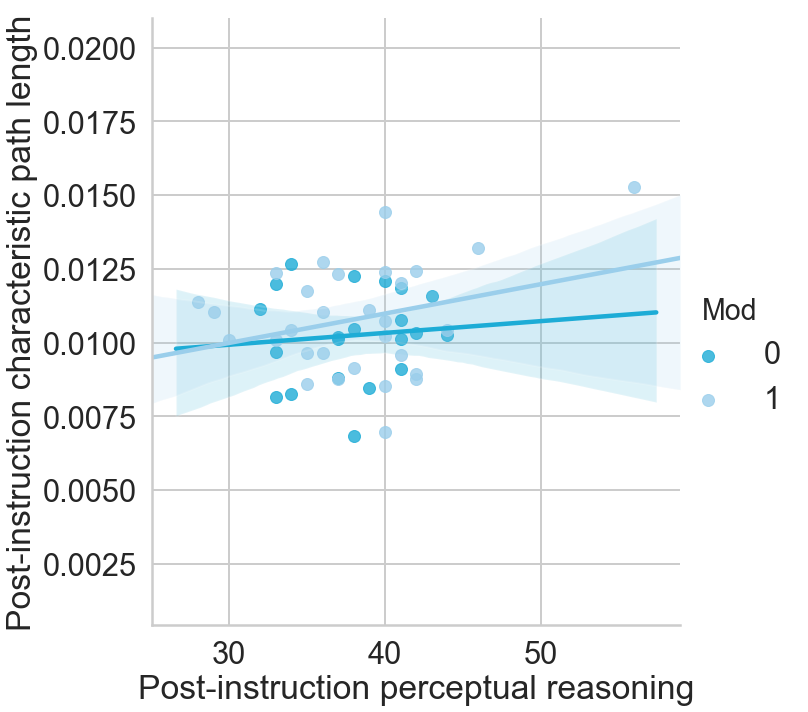

In [48]:
h = sns.lmplot('Perceptual Reasoning Sum_2', 'post phys retr shen cpl', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10., )

h.set_xlabels('Post-instruction perceptual reasoning')
h.set_ylabels('Post-instruction characteristic path length')
h.savefig(join(fig_dir, 'RETR_phys_post-cplXpost-priq_m.png'), dpi=300)

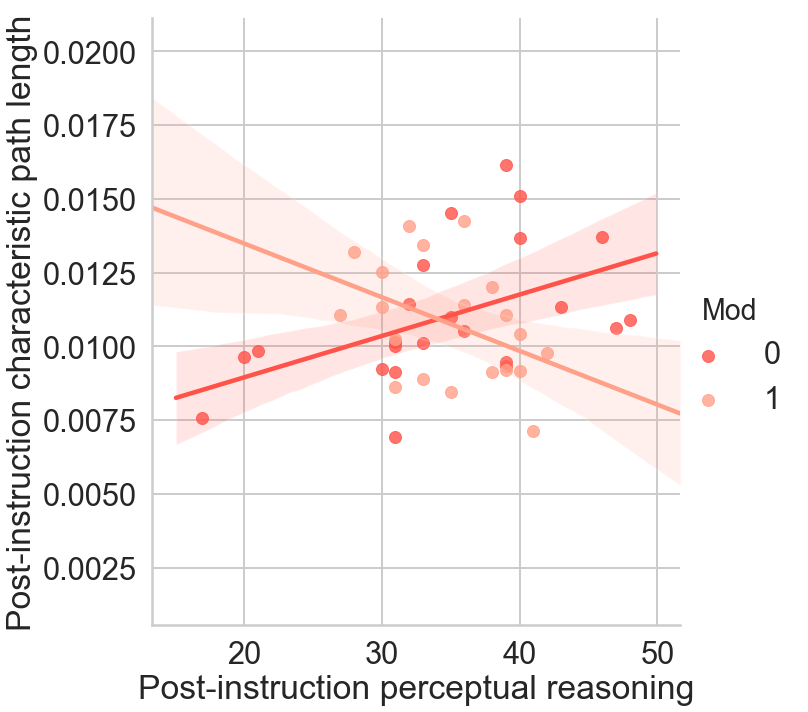

In [49]:
h = sns.lmplot('Perceptual Reasoning Sum_2', 'post phys retr shen cpl', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction perceptual reasoning')
h.set_ylabels('Post-instruction characteristic path length')
h.savefig(join(fig_dir, 'RETR_phys_post-cplXpost-priq_f.png'), dpi=300)

# General retrieval and deltaPRIQ

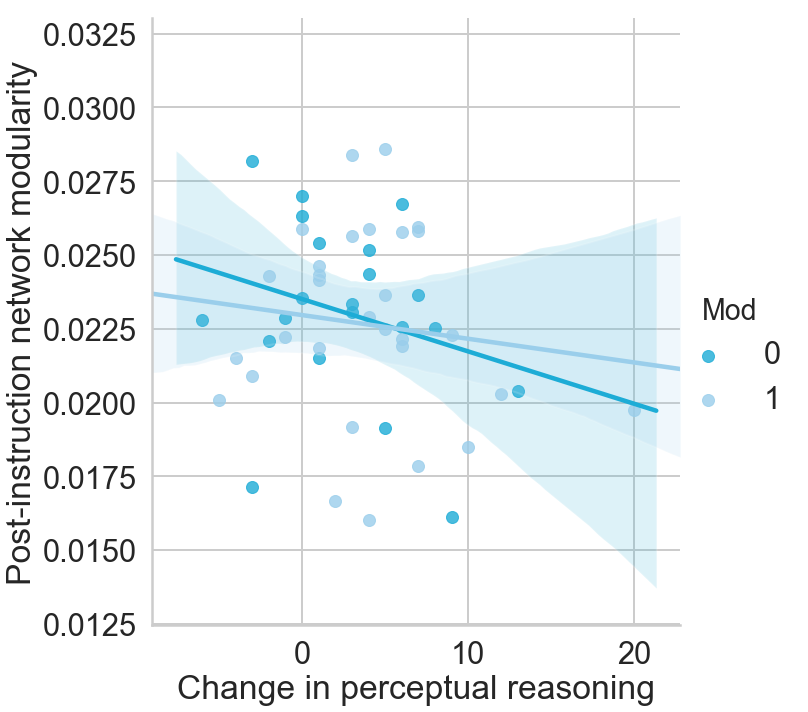

In [50]:
h = sns.lmplot('delta Perceptual Reasoning', 'post gen retr shen mod', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Change in perceptual reasoning')
h.set_ylabels('Post-instruction network modularity')
h.savefig(join(fig_dir, 'RETR_gen_post-modXdelta-priq_m.png'), dpi=300)

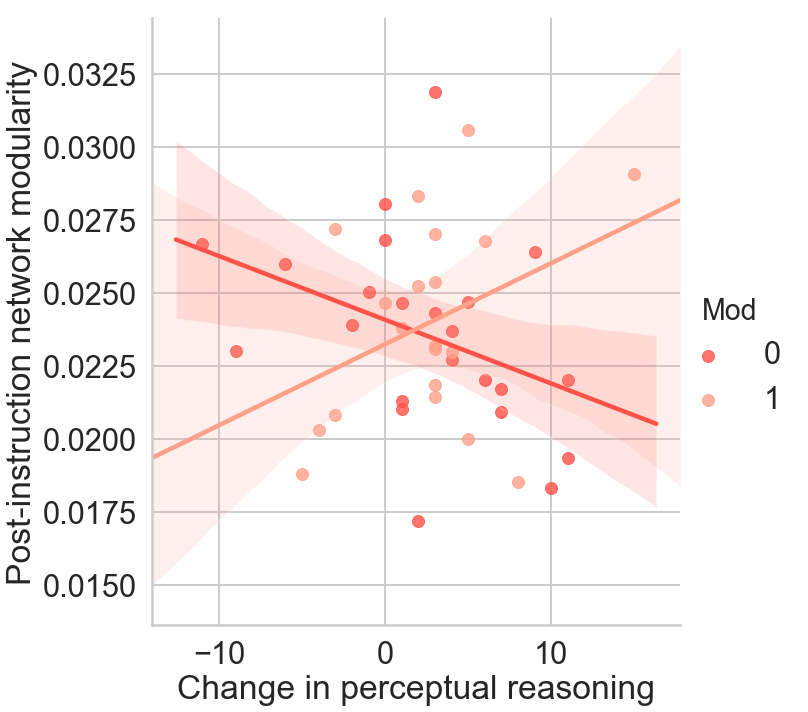

In [51]:
h = sns.lmplot('delta Perceptual Reasoning', 'post gen retr shen mod', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Change in perceptual reasoning')
h.set_ylabels('Post-instruction network modularity')
h.savefig(join(fig_dir, 'RETR_gen_post-modXdelta-priq_f.png'), dpi=300)

# Physics Retrieval & FSIQ

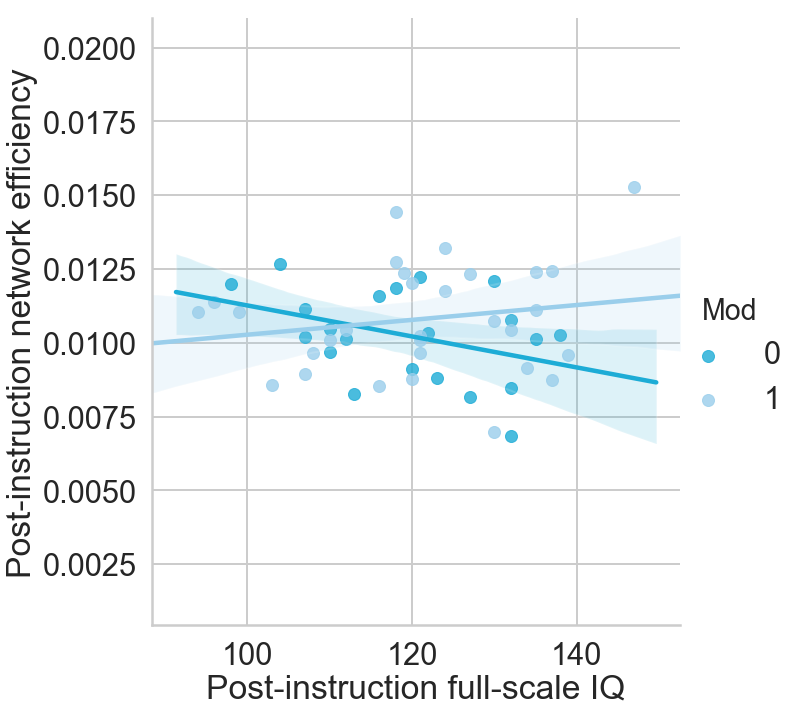

In [43]:
h = sns.lmplot('Full Scale IQ_2', 'post phys retr shen cpl', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction full-scale IQ')
h.set_ylabels('Post-instruction network efficiency')
h.savefig(join(fig_dir, 'RETR_phys_post-cplXpost-fsiq_m.png'), dpi=300)

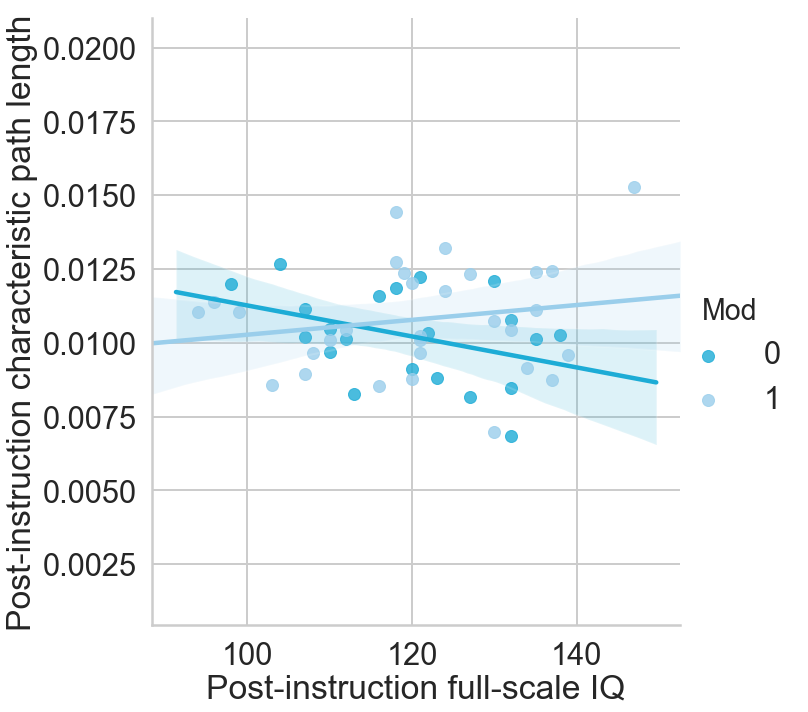

In [40]:
h = sns.lmplot('Full Scale IQ_2', 'post phys retr shen cpl', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction full-scale IQ')
h.set_ylabels('Post-instruction characteristic path length')
#h.savefig(join(fig_dir, 'pre_prXpre_eff_inf-m.png'), dpi=300)

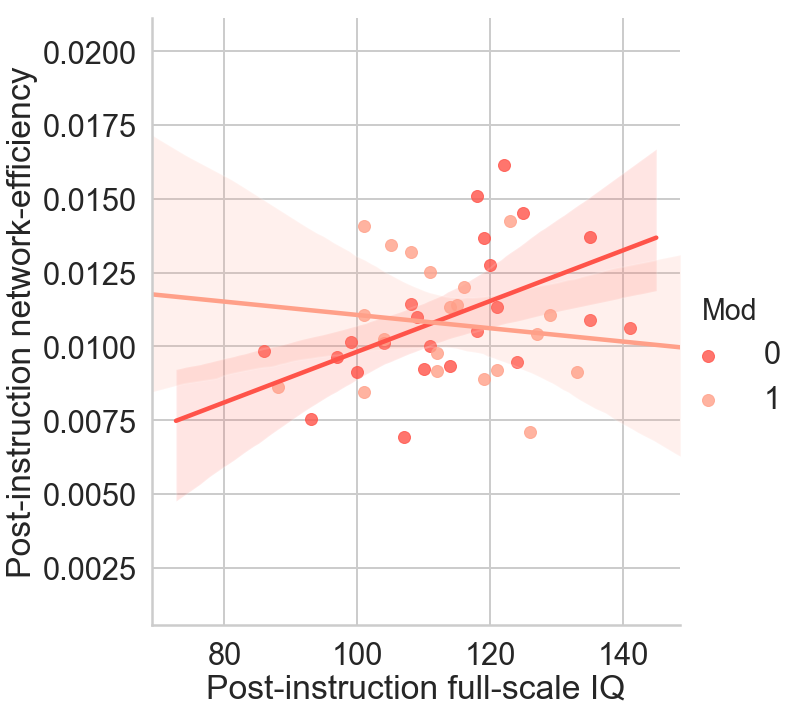

In [44]:
h = sns.lmplot('Full Scale IQ_2', 'post phys retr shen cpl', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction full-scale IQ')
h.set_ylabels('Post-instruction network-efficiency')
h.savefig(join(fig_dir, 'RETR_phys_post-cplXpost-fsiq_f.png'), dpi=300)

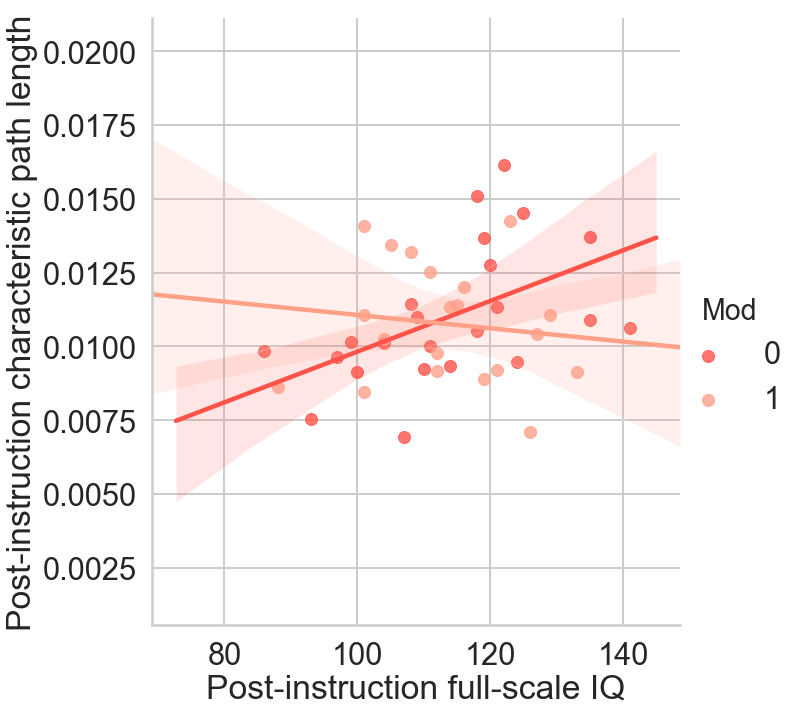

In [42]:
h = sns.lmplot('Full Scale IQ_2', 'post phys retr shen cpl', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction full-scale IQ')
h.set_ylabels('Post-instruction characteristic path length')
#h.savefig(join(fig_dir, 'pre_prXpre_eff_inf-m.png'), dpi=300)

# FCI and PRIQ

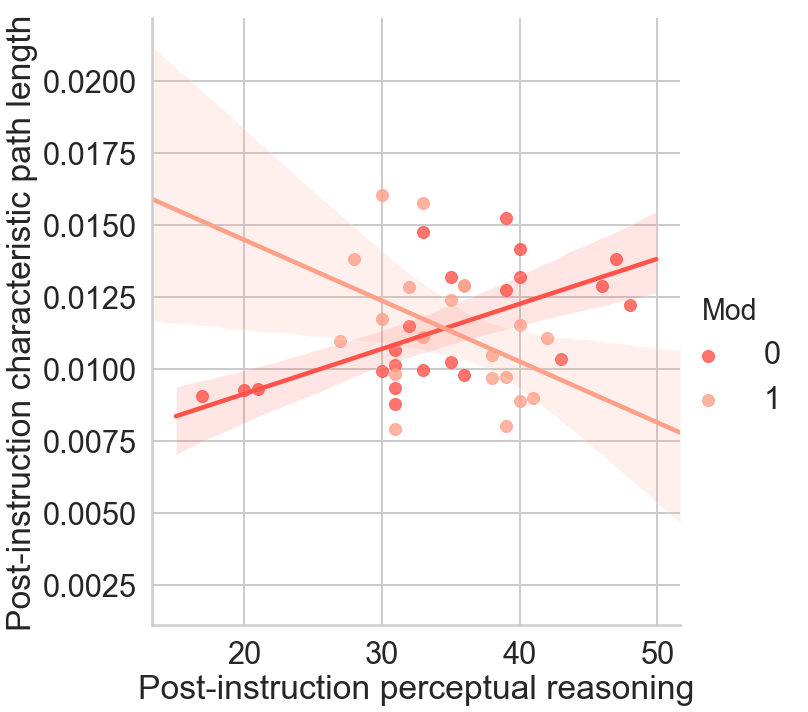

In [52]:
h = sns.lmplot('Perceptual Reasoning Sum_2', 'post phys fci shen cpl', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction perceptual reasoning')
h.set_ylabels('Post-instruction characteristic path length')
h.savefig(join(fig_dir, 'FCI_phys_post-cplXpost-priq_f.png'), dpi=300)

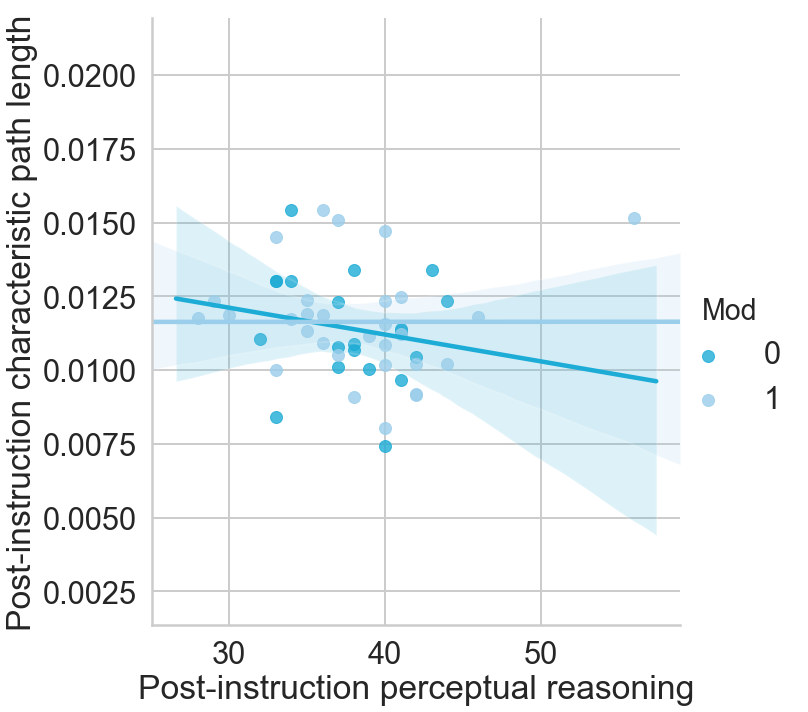

In [53]:
h = sns.lmplot('Perceptual Reasoning Sum_2', 'post phys fci shen cpl', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction perceptual reasoning')
h.set_ylabels('Post-instruction characteristic path length')
h.savefig(join(fig_dir, 'FCI_phys_post-cplXpost-priq_m.png'), dpi=300)

# FCI and FSIQ

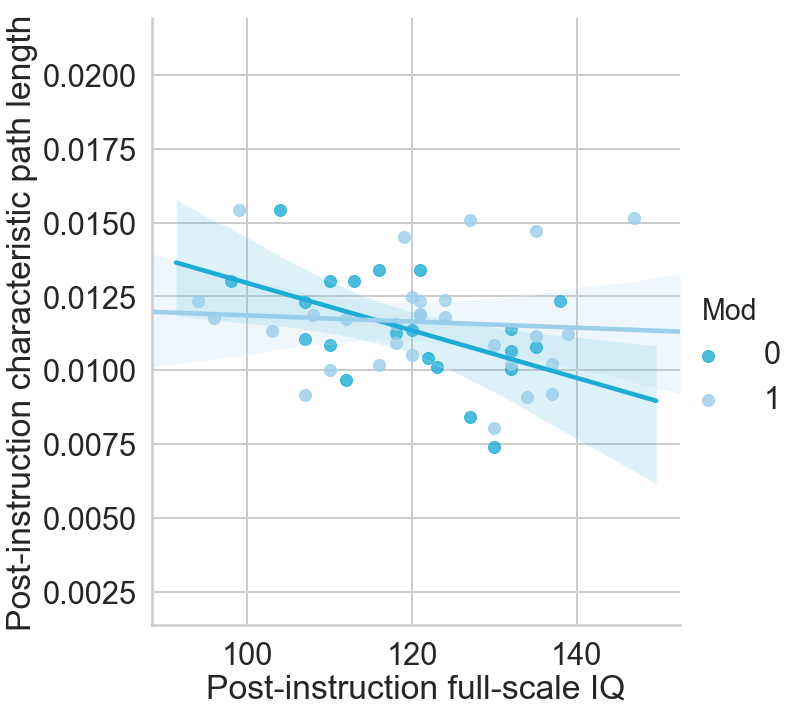

In [54]:
h = sns.lmplot('Full Scale IQ_2', 'post phys fci shen cpl', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction full-scale IQ')
h.set_ylabels('Post-instruction characteristic path length')
h.savefig(join(fig_dir, 'FCI_phys_post-cplXpost-fsiq_m.png'), dpi=300)

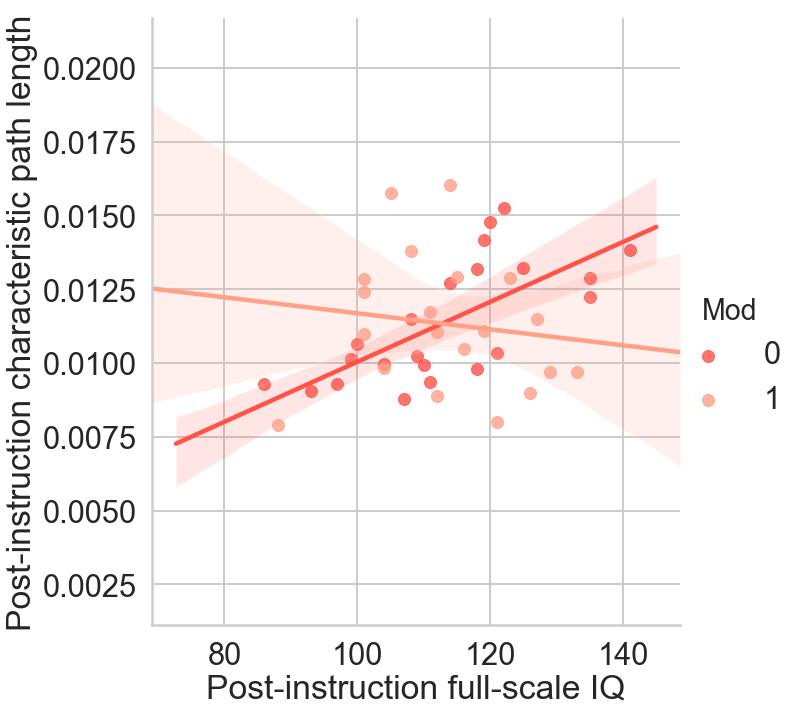

In [55]:
h = sns.lmplot('Full Scale IQ_2', 'post phys fci shen cpl', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Post-instruction full-scale IQ')
h.set_ylabels('Post-instruction characteristic path length')
h.savefig(join(fig_dir, 'FCI_phys_post-cplXpost-fsiq_f.png'), dpi=300)

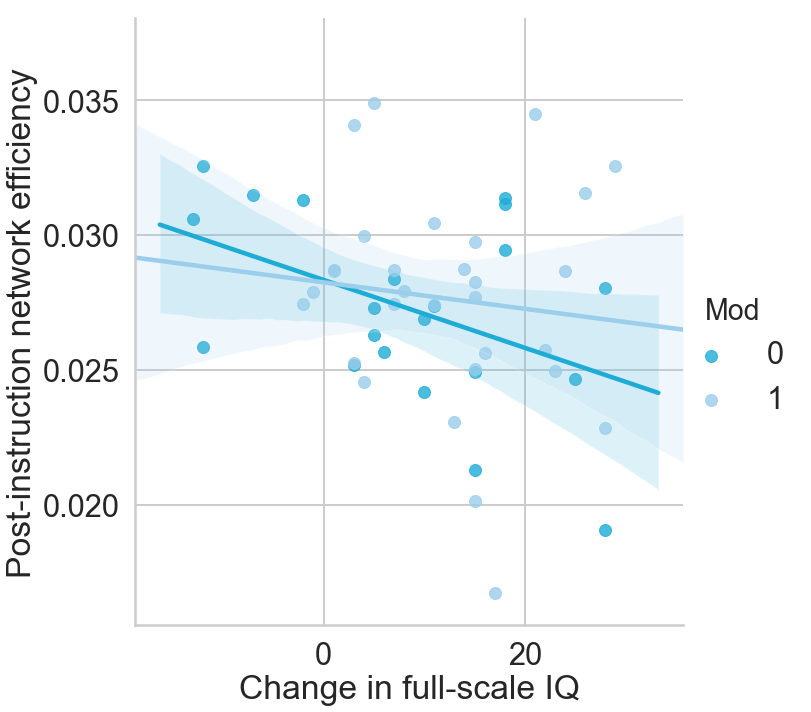

In [49]:
h = sns.lmplot('delta Full Scale IQ', 'post phys fci shen eff', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Change in full-scale IQ')
h.set_ylabels('Post-instruction network efficiency')
h.savefig(join(fig_dir, 'FCI_phys_post-effXdelta-fsiq_m.png'), dpi=300)

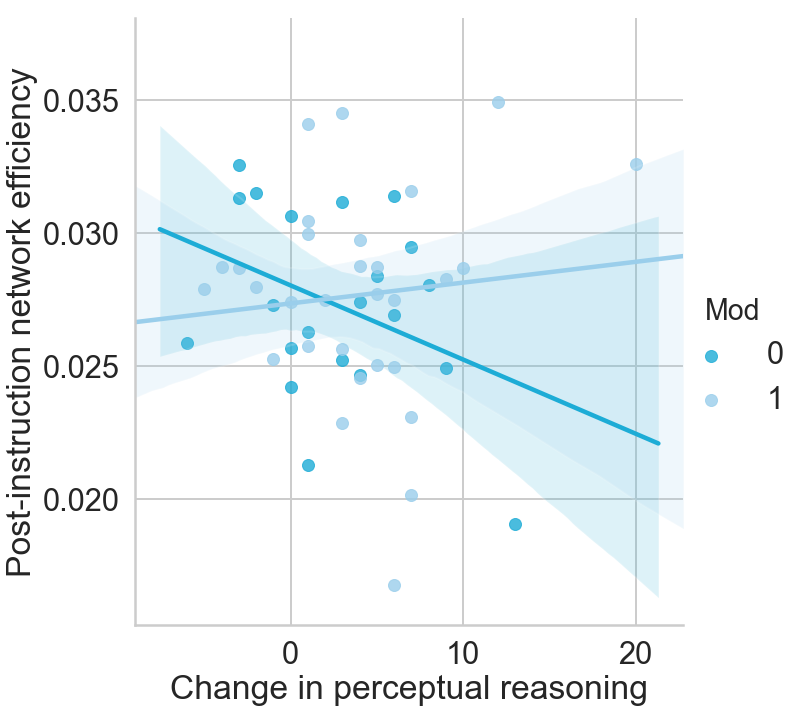

In [50]:
h = sns.lmplot('delta Perceptual Reasoning', 'post phys fci shen eff', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Change in perceptual reasoning')
h.set_ylabels('Post-instruction network efficiency')
h.savefig(join(fig_dir, 'FCI_phys_post-effXdelta-priq_m.png'), dpi=300)

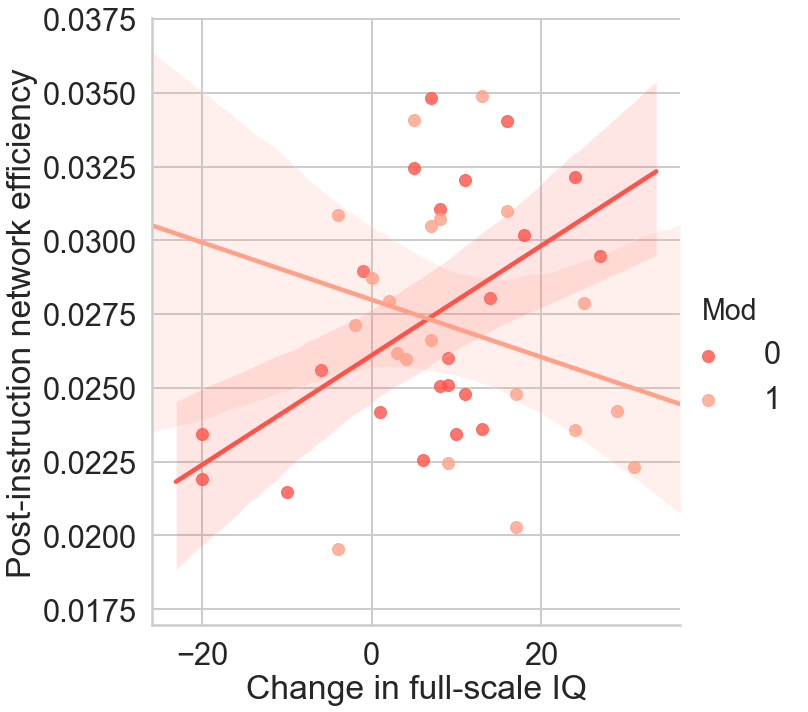

In [51]:
h = sns.lmplot('delta Full Scale IQ', 'post phys fci shen eff', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Change in full-scale IQ')
h.set_ylabels('Post-instruction network efficiency')
h.savefig(join(fig_dir, 'FCI_phys_post-effXdelta-fsiq_f.png'), dpi=300)

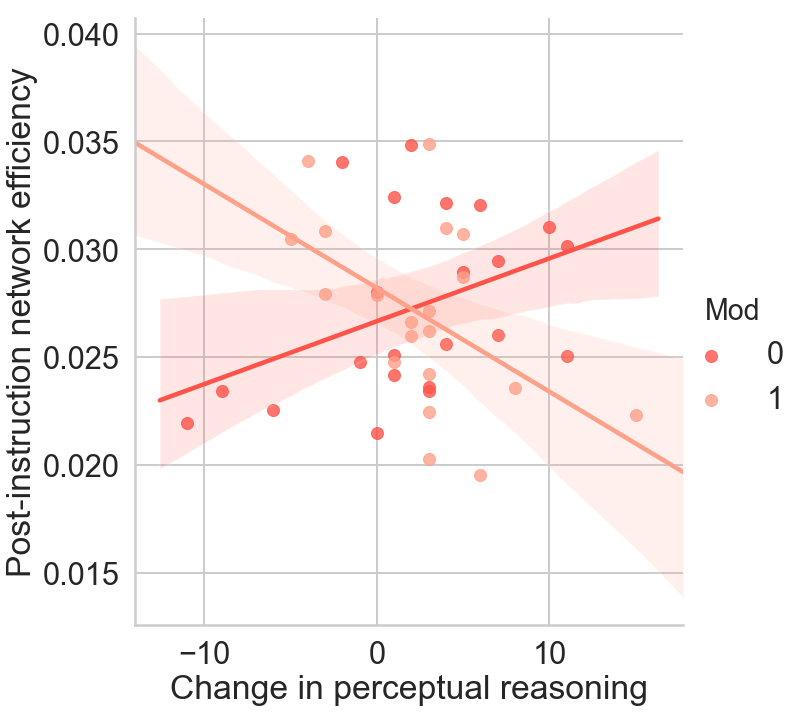

In [52]:
h = sns.lmplot('delta Perceptual Reasoning', 'post phys fci shen eff', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Change in perceptual reasoning')
h.set_ylabels('Post-instruction network efficiency')
h.savefig(join(fig_dir, 'FCI_phys_post-effXdelta-priq_f.png'), dpi=300)

# Reasoning and WMIQ

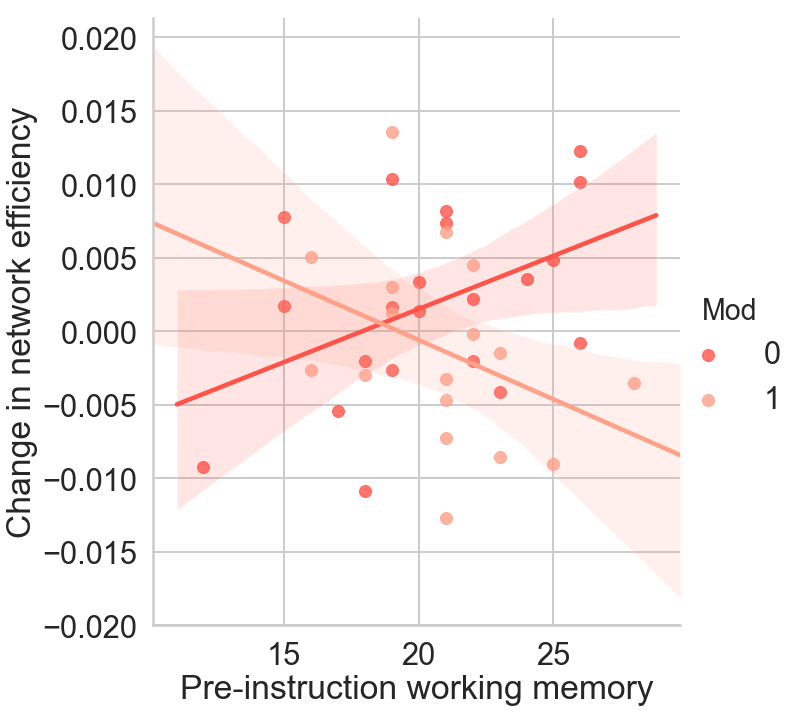

In [53]:
h = sns.lmplot('Working Memory Sum_1', 'delta infr reas shen eff', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)

h.set_xlabels('Pre-instruction working memory')
h.set_ylabels('Change in network efficiency')
h.savefig(join(fig_dir, 'REAS_infr_delta-effXpre-wmiq_f.png'), dpi=300)

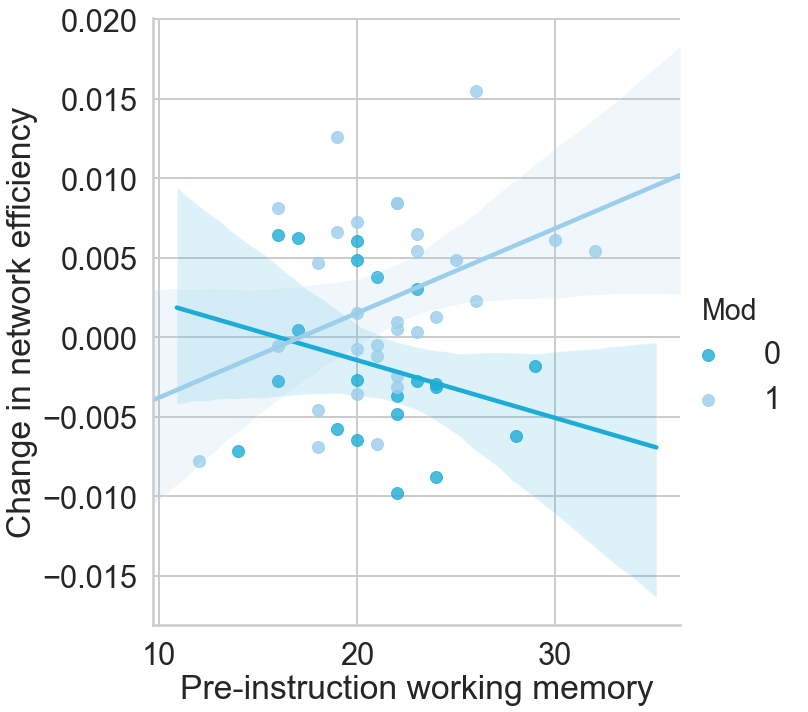

In [54]:
h = sns.lmplot('Working Memory Sum_1', 'delta infr reas shen eff', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)

h.set_xlabels('Pre-instruction working memory')
h.set_ylabels('Change in network efficiency')
h.savefig(join(fig_dir, 'REAS_infr_delta-effXpre-wmiq_m.png'), dpi=300)

In [2]:
import seaborn as sns
sns.set()